In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
from statsmodels.tsa.stattools import adfuller
import datetime
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.dates as mdates
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Eleccion Modelo ML

In [3]:
mensual = pd.read_csv('mensual.csv')
mensual['pickup_datetime'] = pd.to_datetime(mensual['pickup_datetime'])
mensual.set_index('pickup_datetime', inplace=True)

In [ ]:
diario = pd.read_csv('diario.csv')
semanal = pd.read_csv('semanal.csv')
mensual = pd.read_csv('mensual.csv')

In [ ]:
diario['pickup_datetime'] = pd.to_datetime(diario['pickup_datetime'])
semanal['pickup_datetime'] = pd.to_datetime(semanal['pickup_datetime'])
mensual['pickup_datetime'] = pd.to_datetime(mensual['pickup_datetime'])

In [ ]:
diario.set_index('pickup_datetime', inplace=True)
mensual.set_index('pickup_datetime', inplace=True)
semanal.set_index('pickup_datetime', inplace=True)

In [ ]:
diario.head()

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-05,107088,152369.55,1746995.00,1.040973e+06,84509.0
2023-09-06,125811,179210.26,2181041.47,1.381579e+06,100073.0
2023-09-07,139797,199385.39,2453146.14,1.579063e+06,110657.0
2023-09-08,136767,187498.75,2299946.76,1.473957e+06,104886.0
2023-09-09,140098,190146.87,2148279.09,1.380598e+06,100666.0


In [ ]:
semanal.head()

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-17,860067,1215057.15,14395656.38,9.061134e+06,665479.0
2023-09-24,379317,536201.11,6733854.78,4.294240e+06,586816.0
2023-10-01,840174,1177465.37,13800304.01,8.531493e+06,647820.0
2023-10-08,871700,1223806.22,14176927.80,8.775225e+06,664636.0
2023-10-15,865999,1207735.18,14104448.20,8.814019e+06,659893.0


In [3]:
mensual.head()

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-30,2732993,3840800.70,45795129.41,2.875794e+07,2403633.0
2023-10-31,3898868,5472308.86,63778214.48,3.970597e+07,2978961.0
2023-11-30,3726416,5136505.72,60388236.66,3.754072e+07,2841540.0
2023-12-31,3890520,5266948.52,61323166.56,3.819132e+07,2936035.0
2024-01-31,3310266,4670785.61,51801929.35,3.013794e+07,2567477.0


## Preparacion

In [4]:
mensual['fecha_numeros']=mensual.index.map(datetime.datetime.toordinal)
#semanal['fecha_numeros']=semanal.index.map(datetime.datetime.toordinal)
#diario['fecha_numeros']=diario.index.map(datetime.datetime.toordinal)

### Verificacion de estacionariedad

In [5]:
#H0: No es estacionaria
#H1: Es estacionaria
def adfuller_test(trips):
    result = adfuller(trips)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print('Es estacionaria.')
    else:
        print('No es estacionaria.')

In [ ]:
adfuller_test(diario.n_trips)

ADF Test Statistic : -3.139692525320361
p-value : 0.023751837758042283
#Lags Used : 15
Number of Observations Used : 346
Es estacionaria.


In [ ]:
adfuller_test(semanal.n_trips)

ADF Test Statistic : -3.1430268483560035
p-value : 0.02352857488261235
#Lags Used : 0
Number of Observations Used : 46
Es estacionaria.


In [6]:
adfuller_test(mensual.n_trips)

ADF Test Statistic : -1.6094009864898395
p-value : 0.47886955144977916
#Lags Used : 3
Number of Observations Used : 8
No es estacionaria.


## Regresion Lineal

In [ ]:
reg_lineal_d = LinearRegression() #Instanciamos el modelo

reg_lineal_d.fit(diario.fecha_numeros.values.reshape(-1, 1), diario.n_trips) # Entrenamos el modelo con los datos de entrenamiento (fecha y temperatura)

LinearRegression()

In [ ]:
reg_lineal_s = LinearRegression() #Instanciamos el modelo

reg_lineal_s.fit(semanal.fecha_numeros.values.reshape(-1, 1), semanal.n_trips) # Entrenamos el modelo con los datos de entrenamiento (fecha y temperatura)

LinearRegression()

In [ ]:
reg_lineal_m = LinearRegression() #Instanciamos el modelo

reg_lineal_m.fit(mensual.fecha_numeros.values.reshape(-1, 1), mensual.n_trips) # Entrenamos el modelo con los datos de entrenamiento (fecha y temperatura)

LinearRegression()

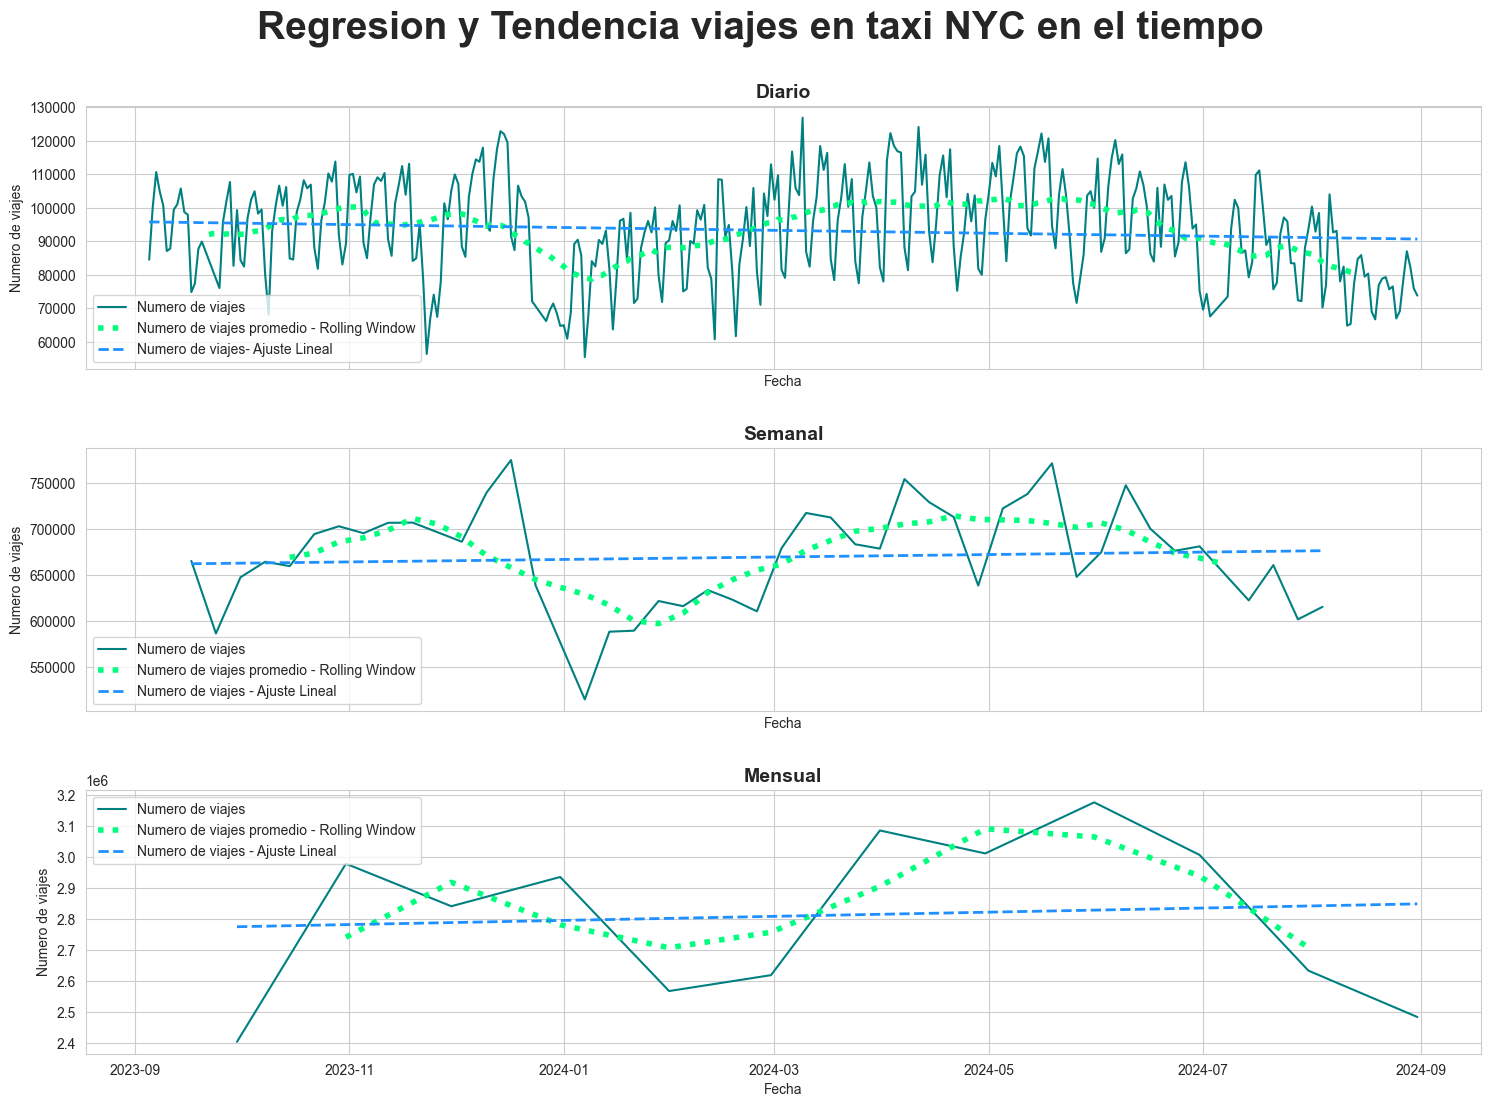

In [ ]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(3,1, figsize = (18,12), gridspec_kw={'height_ratios': [1, 1,1]}, sharex=True)
fig.suptitle("Regresion y Tendencia viajes en taxi NYC en el tiempo",fontsize=28, fontweight='bold')
plt.subplots_adjust(top=0.9,hspace=0.3)

ventana = (35)
diario_promedio_tendencia = diario.n_trips.rolling(window=ventana, center = True).mean()
ax[0].plot(diario.index, diario.n_trips, label = 'Numero de viajes', color='teal')
ax[0].plot(diario_promedio_tendencia, lw = 4, linestyle=":", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[0].plot(diario.index, reg_lineal_d.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 2, linestyle="--", label = 'Numero de viajes- Ajuste Lineal', color='dodgerblue')
ax[0].set_xlabel('Fecha')
ax[0].set_ylabel('Numero de viajes')
ax[0].set_title('Diario',fontsize=14, fontweight='bold')
ax[0].legend()

ventana = (9)
semanal_promedio_tendencia = semanal.n_trips.rolling(window=ventana, center = True).mean()
ax[1].plot(semanal.index, semanal.n_trips, label = 'Numero de viajes', color='teal')
ax[1].plot(semanal_promedio_tendencia, lw = 4, linestyle=":", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[1].plot(semanal.index, reg_lineal_s.predict(semanal.fecha_numeros.values.reshape(-1, 1)), lw = 2, linestyle="--", label = 'Numero de viajes - Ajuste Lineal', color='dodgerblue')
ax[1].set_xlabel('Fecha')
ax[1].set_ylabel('Numero de viajes')
ax[1].set_title('Semanal',fontsize=14, fontweight='bold')
ax[1].legend()

ventana = (3)
mensual_promedio_tendencia = mensual.n_trips.rolling(window=ventana, center = True).mean()
ax[2].plot(mensual.index, mensual.n_trips, label = 'Numero de viajes', color='teal')
ax[2].plot(mensual_promedio_tendencia, lw = 4, linestyle=":", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[2].plot(mensual.index, reg_lineal_m.predict(mensual.fecha_numeros.values.reshape(-1, 1)), lw = 2, linestyle="--", label = 'Numero de viajes - Ajuste Lineal', color='dodgerblue')
ax[2].set_xlabel('Fecha')
ax[2].set_ylabel('Numero de viajes')
ax[2].set_title('Mensual',fontsize=14, fontweight='bold')
ax[2].legend()

plt.show()

## Frecuencia Mensual

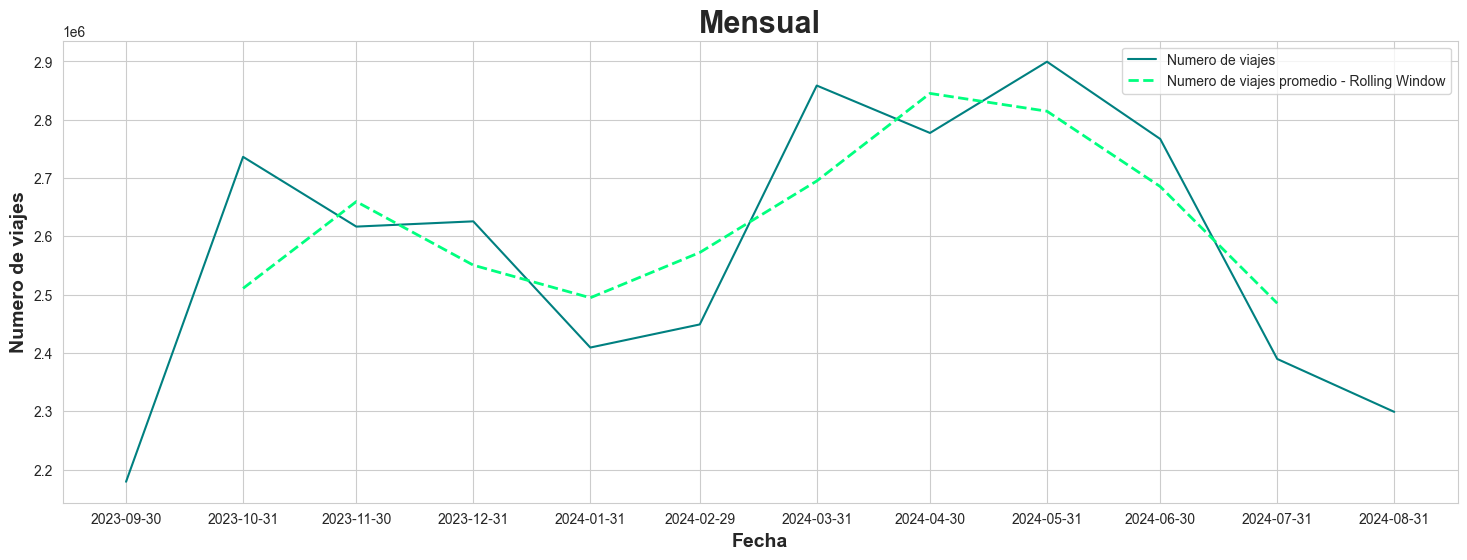

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(18,6))

ventana = (3)
mensual_promedio_tendencia = mensual.n_trips.rolling(window=ventana, center = True).mean()
plt.plot(mensual.index, mensual.n_trips, label = 'Numero de viajes', color='teal')
plt.plot(mensual_promedio_tendencia, lw = 2, linestyle="--", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
plt.xlabel('Fecha',fontsize=14, fontweight='bold')
plt.ylabel('Numero de viajes',fontsize=14, fontweight='bold')
plt.xticks(ticks=mensual.index)
plt.title('Mensual',fontsize=22, fontweight='bold')
plt.legend()

In [8]:
mensual['month_diff'] = mensual['n_trips'] - mensual['n_trips'].shift(1)
mensual['month_diff']

pickup_datetime
2023-09-30         NaN
2023-10-31    557189.0
2023-11-30   -119632.0
2023-12-31      9011.0
2024-01-31   -216426.0
2024-02-29     39610.0
2024-03-31    409709.0
2024-04-30    -81299.0
2024-05-31    122177.0
2024-06-30   -132507.0
2024-07-31   -377281.0
2024-08-31    -90750.0
Name: month_diff, dtype: float64

In [9]:
adfuller_test(mensual['month_diff'].dropna())

ADF Test Statistic : -3.937122907985795
p-value : 0.00177800862115977
#Lags Used : 0
Number of Observations Used : 10
Es estacionaria.


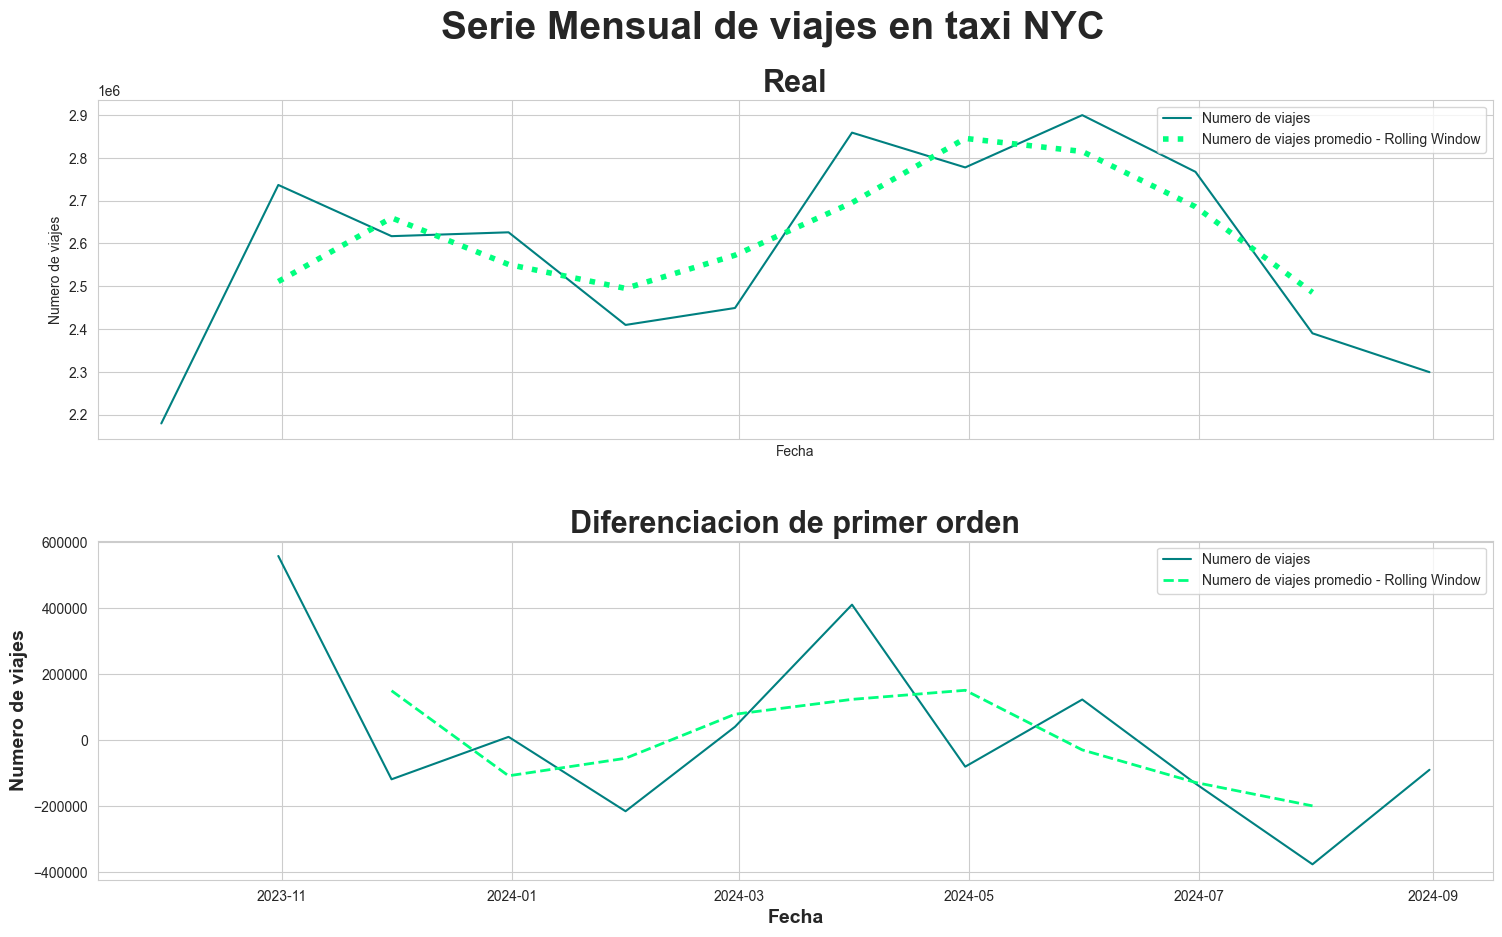

In [10]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(2,1, figsize = (18,10), gridspec_kw={'height_ratios': [1,1]}, sharex=True)
fig.suptitle("Serie Mensual de viajes en taxi NYC",fontsize=28, fontweight='bold')
plt.subplots_adjust(top=0.89,hspace=0.3)

ventana = (3)
mensual_promedio_tendencia = mensual.n_trips.rolling(window=ventana, center = True).mean()
ax[0].plot(mensual.index, mensual.n_trips, label = 'Numero de viajes', color='teal')
ax[0].plot(mensual_promedio_tendencia, lw = 4, linestyle=":", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[0].set_xlabel('Fecha')
ax[0].set_ylabel('Numero de viajes')
ax[0].set_title('Real',fontsize=22, fontweight='bold')
ax[0].legend()

ventana = (3)
mensual_promedio_tendencia = mensual['month_diff'].rolling(window=ventana, center = True).mean()
ax[1].plot(mensual.index, mensual['month_diff'], label = 'Numero de viajes', color='teal')
ax[1].plot(mensual_promedio_tendencia, lw = 2, linestyle="--", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[1].set_xlabel('Fecha',fontsize=14, fontweight='bold')
ax[1].set_ylabel('Numero de viajes',fontsize=14, fontweight='bold')
ax[1].set_title('Diferenciacion de primer orden',fontsize=22, fontweight='bold')
ax[1].legend()

plt.show()

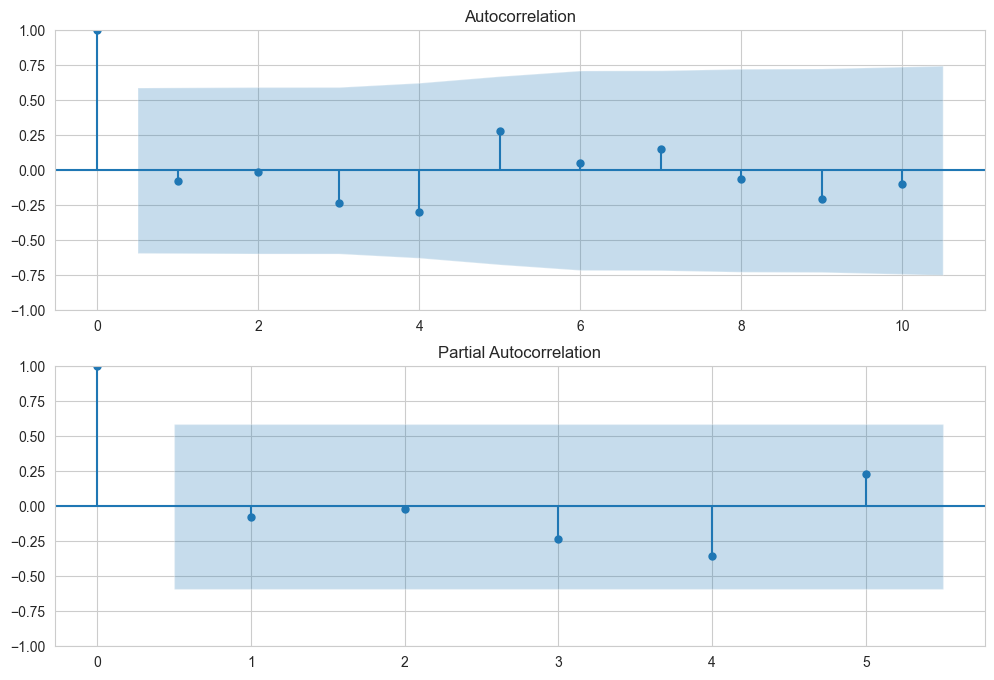

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(mensual['month_diff'].iloc[1:], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(mensual['month_diff'].iloc[1:], lags=5, ax=ax2)
plt.show()

In [12]:
from statsmodels.tsa.arima.model import ARIMA

## ARIMA

- p: orden del modelo AR (autoregresivo)
- d: orden de integración (número de diferencias no estacionales)
- q: orden del modelo MA (media móvil)

In [13]:
model = ARIMA(mensual['month_diff'],order=(2,1,1))
model_fit=model.fit()

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             month_diff   No. Observations:                   12
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -155.097
Date:                Tue, 12 Nov 2024   AIC                            318.193
Time:                        23:52:39   BIC                            319.785
Sample:                    09-30-2023   HQIC                           317.190
                         - 08-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3098      0.270     -4.846      0.000      -1.840      -0.780
ar.L2         -0.6906      0.306     -2.259      0.024      -1.290      -0.091
ma.L1          0.9624      0.858      1.121      0.262      -0.720       2.645
sigma2      8.554e+10   1.04e-11   8.22e+21      0.000    8.55e+10    8.55e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.88   Prob(JB):                         0.68
Heteroskedasticity (H):               0.29   Skew:                             0.35
Prob(H) (two-sided):                  0.26   Kurtosis:                         1.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.53e+37. Standard errors may be unstable.
"""

In [14]:
last_date = mensual.index[-1]
forecast=model_fit.predict(start = last_date, end = last_date + pd.DateOffset(months=12), dynamic = True)

In [15]:
forecast_df = pd.DataFrame({'month_diff': forecast}, index=pd.date_range(start=last_date, periods=13, freq='M')[1:])
forecast_df

,month_diff
2024-09-30,-286758.732052
2024-10-31,-230628.585407
2024-11-30,-161043.864110
2024-12-31,-287201.644574
2025-01-31,-175788.005754
2025-02-28,-229881.040287
2025-03-31,-237960.759899
2025-04-30,-190740.255050
2025-05-31,-244741.976996
2025-06-30,-208987.962726


In [16]:
forecast_df

,month_diff
2024-09-30,-286758.732052
2024-10-31,-230628.585407
2024-11-30,-161043.864110
2024-12-31,-287201.644574
2025-01-31,-175788.005754
2025-02-28,-229881.040287
2025-03-31,-237960.759899
2025-04-30,-190740.255050
2025-05-31,-244741.976996
2025-06-30,-208987.962726


In [17]:
mensual

,passenger_count,trip_distance,total_amount,duration,n_trips,fecha_numeros,month_diff
pickup_datetime,,,,,,,
2023-09-30,2834965,3460189.95,43351361.13,2.606321e+07,2179200,738793,NaN
2023-10-31,3576133,4382900.21,54676872.61,3.301915e+07,2736389,738824,557189.0
2023-11-30,3427883,4139501.57,51979545.55,3.135258e+07,2616757,738854,-119632.0
2023-12-31,3541070,4167204.54,51955671.11,3.122333e+07,2625768,738885,9011.0
2024-01-31,3104773,3883527.49,46044469.28,2.626918e+07,2409342,738916,-216426.0
2024-02-29,3124501,3959766.71,47253940.40,2.747364e+07,2448952,738945,39610.0
2024-03-31,3628203,4703052.88,55237790.42,3.265720e+07,2858661,738976,409709.0
2024-04-30,3513134,4646128.88,54112655.33,3.226751e+07,2777362,739006,-81299.0
2024-05-31,3665269,4793006.98,57431400.26,3.453748e+07,2899539,739037,122177.0


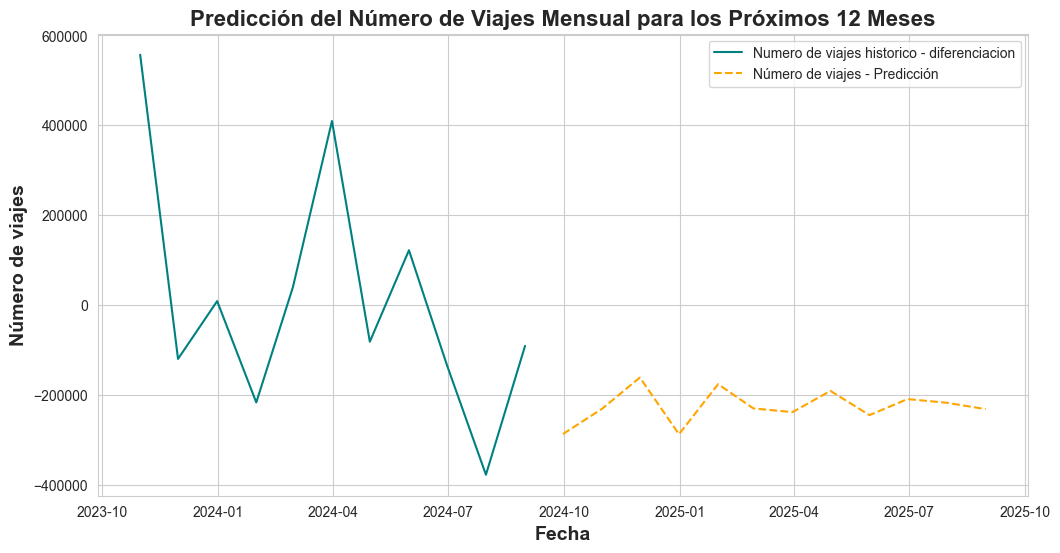

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(mensual.index, mensual['month_diff'], label='Numero de viajes historico - diferenciacion', color='teal')
plt.plot(forecast_df.index,forecast_df['month_diff'] , label='Número de viajes - Predicción', color='orange', linestyle='--')
plt.xlabel('Fecha', fontsize=14, fontweight='bold')
plt.ylabel('Número de viajes', fontsize=14, fontweight='bold')
plt.title('Predicción del Número de Viajes Mensual para los Próximos 12 Meses', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [19]:
# 'differenced_series' es la serie de valores diferenciados
# 'original_series' es la serie original antes de diferenciar

# Valor inicial de la serie (puede ser el primer valor de original_series)
initial_value = mensual['n_trips'].iloc[0]

# Integrar la serie diferenciada usando cumsum
restored_series = mensual['month_diff'].cumsum() + initial_value

# Si estás trabajando con una columna específica de un DataFrame:
mensual['restored_series'] = mensual['month_diff'].cumsum() + mensual['n_trips'].shift(1).fillna(method='bfill')


In [20]:
mensual

,passenger_count,trip_distance,total_amount,duration,n_trips,fecha_numeros,month_diff,restored_series
pickup_datetime,,,,,,,,
2023-09-30,2834965,3460189.95,43351361.13,2.606321e+07,2179200,738793,NaN,NaN
2023-10-31,3576133,4382900.21,54676872.61,3.301915e+07,2736389,738824,557189.0,2736389.0
2023-11-30,3427883,4139501.57,51979545.55,3.135258e+07,2616757,738854,-119632.0,3173946.0
2023-12-31,3541070,4167204.54,51955671.11,3.122333e+07,2625768,738885,9011.0,3063325.0
2024-01-31,3104773,3883527.49,46044469.28,2.626918e+07,2409342,738916,-216426.0,2855910.0
2024-02-29,3124501,3959766.71,47253940.40,2.747364e+07,2448952,738945,39610.0,2679094.0
2024-03-31,3628203,4703052.88,55237790.42,3.265720e+07,2858661,738976,409709.0,3128413.0
2024-04-30,3513134,4646128.88,54112655.33,3.226751e+07,2777362,739006,-81299.0,3456823.0
2024-05-31,3665269,4793006.98,57431400.26,3.453748e+07,2899539,739037,122177.0,3497701.0


In [21]:
restored_series = mensual['month_diff'].copy()

restored_series.iloc[0] = mensual['n_trips'].iloc[0]

for i in range(1, len(restored_series)):
    restored_series.iloc[i] = restored_series.iloc[i] + restored_series.iloc[i - 1]

mensual['restored_series'] = restored_series


In [22]:
restored_series = forecast_df['month_diff'].copy()

restored_series.iloc[0] = mensual['n_trips'].iloc[-1]

for i in range(1, len(restored_series)):
    restored_series.iloc[i] = restored_series.iloc[i] + restored_series.iloc[i - 1]

forecast_df['n_trips'] = restored_series

In [23]:
forecast_df

,month_diff,n_trips
2024-09-30,-286758.732052,2.299001e+06
2024-10-31,-230628.585407,2.068372e+06
2024-11-30,-161043.864110,1.907329e+06
2024-12-31,-287201.644574,1.620127e+06
2025-01-31,-175788.005754,1.444339e+06
2025-02-28,-229881.040287,1.214458e+06
2025-03-31,-237960.759899,9.764971e+05
2025-04-30,-190740.255050,7.857568e+05
2025-05-31,-244741.976996,5.410149e+05
2025-06-30,-208987.962726,3.320269e+05


In [24]:
mensual

,passenger_count,trip_distance,total_amount,duration,n_trips,fecha_numeros,month_diff,restored_series
pickup_datetime,,,,,,,,
2023-09-30,2834965,3460189.95,43351361.13,2.606321e+07,2179200,738793,NaN,2179200.0
2023-10-31,3576133,4382900.21,54676872.61,3.301915e+07,2736389,738824,557189.0,2736389.0
2023-11-30,3427883,4139501.57,51979545.55,3.135258e+07,2616757,738854,-119632.0,2616757.0
2023-12-31,3541070,4167204.54,51955671.11,3.122333e+07,2625768,738885,9011.0,2625768.0
2024-01-31,3104773,3883527.49,46044469.28,2.626918e+07,2409342,738916,-216426.0,2409342.0
2024-02-29,3124501,3959766.71,47253940.40,2.747364e+07,2448952,738945,39610.0,2448952.0
2024-03-31,3628203,4703052.88,55237790.42,3.265720e+07,2858661,738976,409709.0,2858661.0
2024-04-30,3513134,4646128.88,54112655.33,3.226751e+07,2777362,739006,-81299.0,2777362.0
2024-05-31,3665269,4793006.98,57431400.26,3.453748e+07,2899539,739037,122177.0,2899539.0


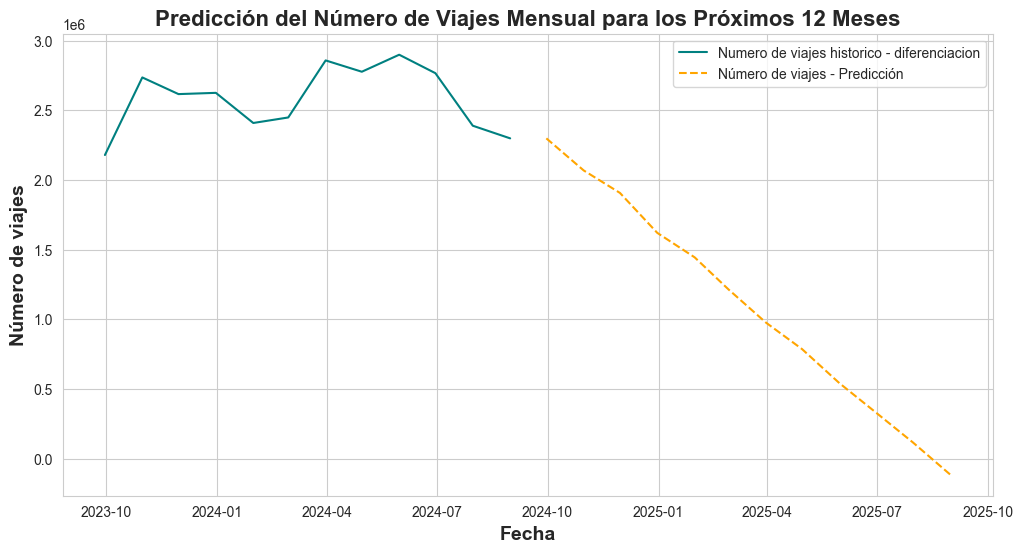

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(mensual.index, mensual['n_trips'], label='Numero de viajes historico - diferenciacion', color='teal')
plt.plot(forecast_df.index,forecast_df['n_trips'] , label='Número de viajes - Predicción', color='orange', linestyle='--')
plt.xlabel('Fecha', fontsize=14, fontweight='bold')
plt.ylabel('Número de viajes', fontsize=14, fontweight='bold')
plt.title('Predicción del Número de Viajes Mensual para los Próximos 12 Meses', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

## SARIMA

In [27]:
# Parámetros para SARIMA: p, d, q, P, D, Q, m
p, d, q = 2, 1, 1  # Componentes no estacionales
P, D, Q, m = 1, 1, 1, 12  # Componentes estacionales, con m=12 para indicar una estacionalidad de 12 meses

# Definir el modelo SARIMA
sarima_model = SARIMAX(mensual['month_diff'],
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, m),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Ajustar el modelo SARIMA
sarima_fit = sarima_model.fit(disp=False)

# Generar pronóstico para los próximos 12 meses
last_date = mensual.index[-1]
forecast_steps = 12
sarima_forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Crear DataFrame de predicción con el índice de fechas
forecast_df = sarima_forecast.summary_frame()
forecast_df.index = forecast_index


In [28]:
forecast_df

month_diff,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-09-30,132125.555425,1483.240088,129218.458271,135032.652579
2024-10-31,355001.222288,1673.320663,351721.574054,358280.870521
2024-11-30,-321819.777712,1673.320961,-325099.426531,-318540.128893
2024-12-31,-193176.777712,1673.321260,-196456.427117,-189897.128308
2025-01-31,-418613.777712,1673.321559,-421893.427703,-415334.127722
2025-02-28,-162577.777712,1673.321858,-165857.428288,-159298.127136
2025-03-31,207521.222288,1673.322157,204241.571126,210800.873449
2025-04-30,-283486.777712,1673.322455,-286766.429460,-280207.125965
2025-05-31,-80010.777712,1673.322754,-83290.430045,-76731.125380
2025-06-30,-334694.777712,1673.323053,-337974.430631,-331415.124794


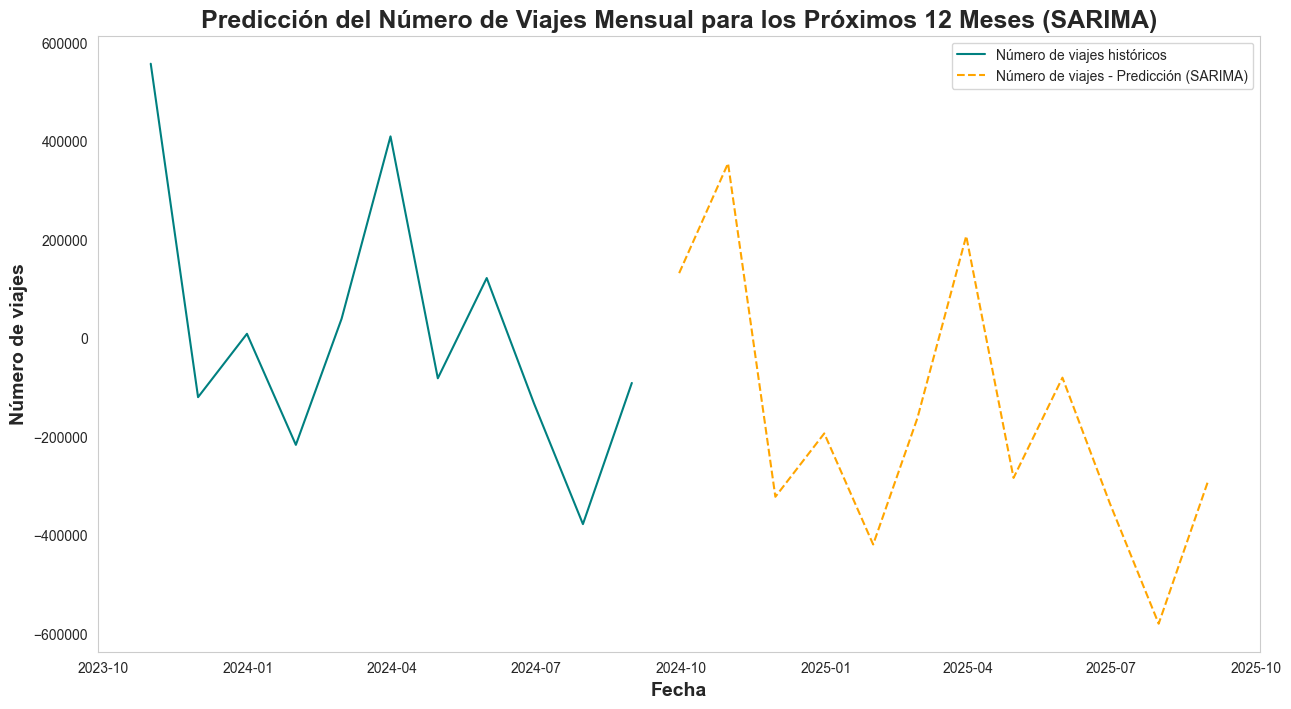

In [30]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
plt.plot(mensual.index, mensual['month_diff'], label='Número de viajes históricos', color='teal')
plt.plot(forecast_df.index, forecast_df['mean'], label='Número de viajes - Predicción (SARIMA)', color='orange', linestyle='--')
plt.xlabel('Fecha', fontsize=14, fontweight='bold')
plt.ylabel('Número de viajes', fontsize=14, fontweight='bold')
plt.title('Predicción del Número de Viajes Mensual para los Próximos 12 Meses (SARIMA)', fontsize=18, fontweight='bold')
plt.legend()
plt.grid()
plt.show()

In [31]:
restored_series = forecast_df['mean'].copy()

restored_series.iloc[0] = mensual['n_trips'].iloc[-1]

for i in range(1, len(restored_series)):
    restored_series.iloc[i] = restored_series.iloc[i] + restored_series.iloc[i - 1]

forecast_df['n_trips'] = restored_series

In [32]:
forecast_df

month_diff,mean,mean_se,mean_ci_lower,mean_ci_upper,n_trips
2024-09-30,132125.555425,1483.240088,129218.458271,135032.652579,2.299001e+06
2024-10-31,355001.222288,1673.320663,351721.574054,358280.870521,2.654002e+06
2024-11-30,-321819.777712,1673.320961,-325099.426531,-318540.128893,2.332182e+06
2024-12-31,-193176.777712,1673.321260,-196456.427117,-189897.128308,2.139006e+06
2025-01-31,-418613.777712,1673.321559,-421893.427703,-415334.127722,1.720392e+06
2025-02-28,-162577.777712,1673.321858,-165857.428288,-159298.127136,1.557814e+06
2025-03-31,207521.222288,1673.322157,204241.571126,210800.873449,1.765335e+06
2025-04-30,-283486.777712,1673.322455,-286766.429460,-280207.125965,1.481849e+06
2025-05-31,-80010.777712,1673.322754,-83290.430045,-76731.125380,1.401838e+06
2025-06-30,-334694.777712,1673.323053,-337974.430631,-331415.124794,1.067143e+06


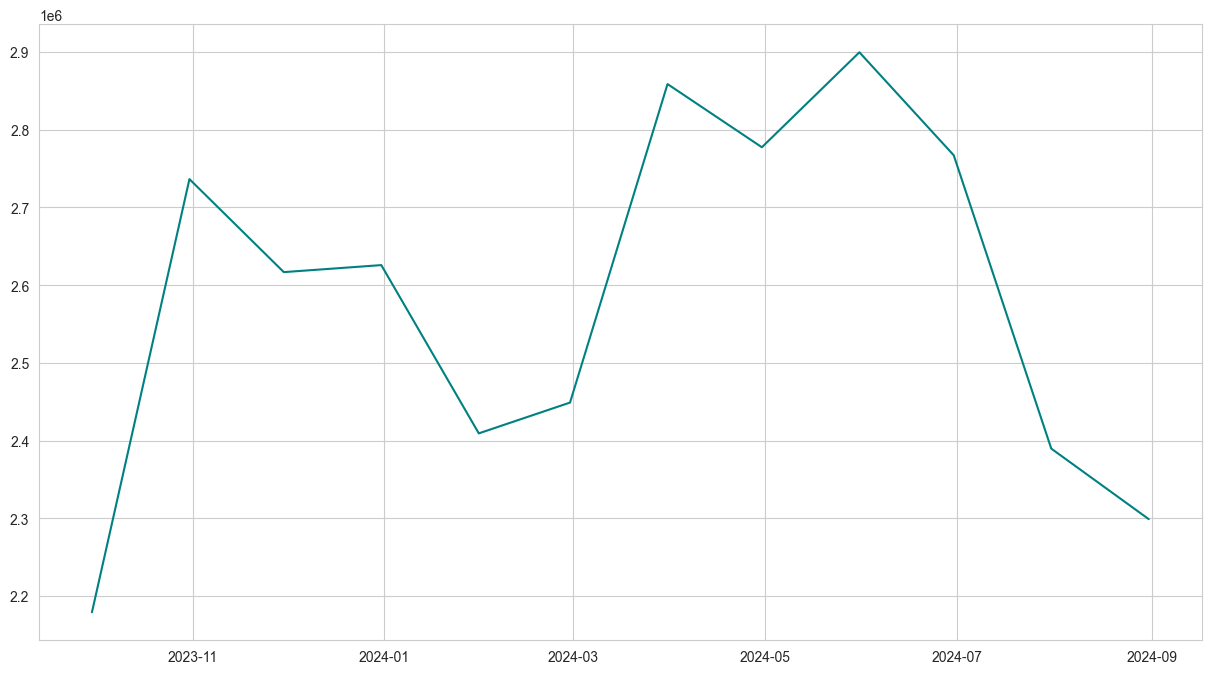

In [37]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
plt.plot(mensual.index, mensual['n_trips'], label='Número de viajes históricos', color='teal')


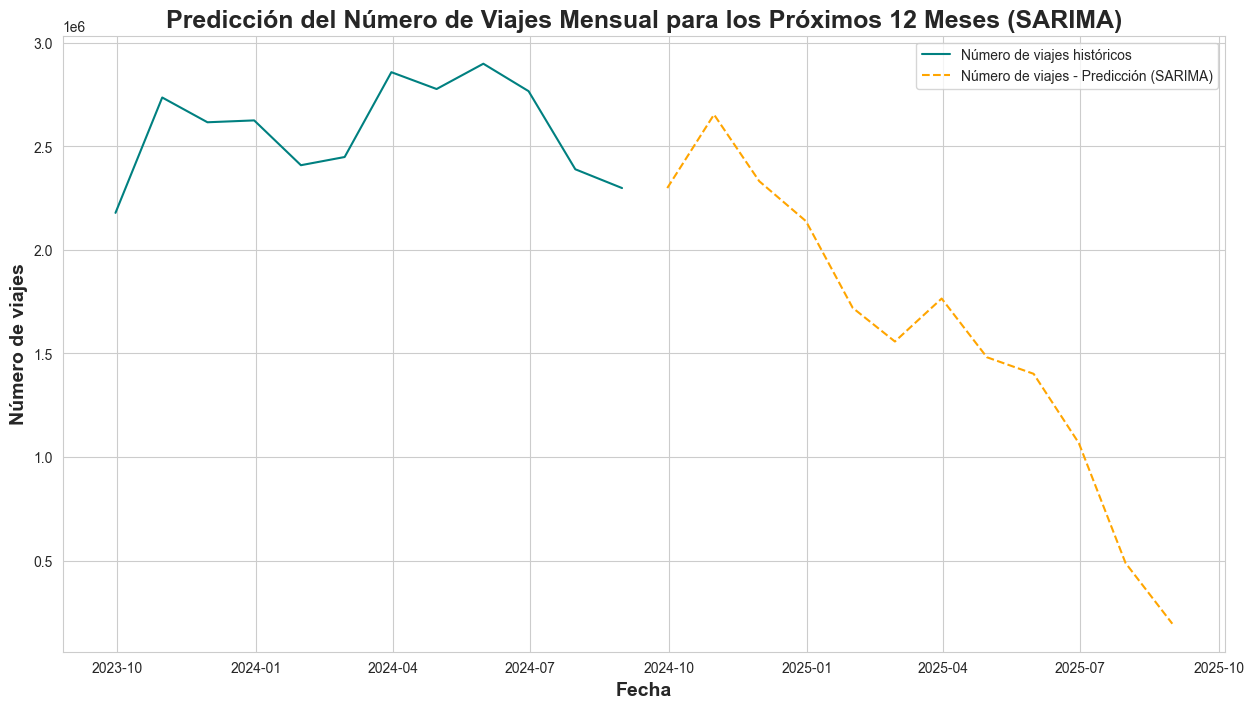

In [38]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
plt.plot(mensual.index, mensual['n_trips'], label='Número de viajes históricos', color='teal')
plt.plot(forecast_df.index, forecast_df['n_trips'], label='Número de viajes - Predicción (SARIMA)', color='orange', linestyle='--')
plt.xlabel('Fecha', fontsize=14, fontweight='bold')
plt.ylabel('Número de viajes', fontsize=14, fontweight='bold')
plt.title('Predicción del Número de Viajes Mensual para los Próximos 12 Meses (SARIMA)', fontsize=18, fontweight='bold')
plt.legend()
plt.show()

In [ ]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

## Prophet

### Diario

In [ ]:
diario

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-05,99802,125552.34,1540935.85,8.975522e+05,78924.0
2023-09-06,114485,141650.92,1844221.48,1.124817e+06,91117.0
2023-09-07,126533,156753.91,2059376.29,1.273202e+06,100287.0
2023-09-08,124365,148088.32,1943639.53,1.199228e+06,95452.0
2023-09-09,126584,147491.51,1787366.36,1.107545e+06,90972.0
...,...,...,...,...,...
2024-08-27,91633,120296.62,1418567.88,8.241690e+05,73266.0
2024-08-28,101202,130843.35,1570150.82,9.204025e+05,81088.0
2024-08-29,96395,124708.58,1498053.45,8.947159e+05,76483.0


In [ ]:
diario_p = diario['n_trips']

In [ ]:
diario_p

,n_trips
pickup_datetime,
2023-09-05,78924.0
2023-09-06,91117.0
2023-09-07,100287.0
2023-09-08,95452.0
2023-09-09,90972.0
...,...
2024-08-27,73266.0
2024-08-28,81088.0
2024-08-29,76483.0


In [ ]:
diario_p = diario_p.reset_index()

In [ ]:
diario_p.rename(columns= {'pickup_datetime': 'ds', 'n_trips' : 'y'}, inplace = True)
diario_p

,ds,y
0,2023-09-05,78924.0
1,2023-09-06,91117.0
2,2023-09-07,100287.0
3,2023-09-08,95452.0
4,2023-09-09,90972.0
...,...,...
357,2024-08-27,73266.0
358,2024-08-28,81088.0
359,2024-08-29,76483.0
360,2024-08-30,70549.0


In [ ]:
# Instanciamos un modelo de Prophet

prophet_1 = Prophet(yearly_seasonality= True, uncertainty_samples = 20, mcmc_samples=20, interval_width= 0.5)

# Entrenamos el modelo
prophet_1.fit(diario_p)

# Construimos un dataframe con los x valores futuros que querámos predecir. 365 dias.
build_forecast = prophet_1.make_future_dataframe(periods=365, freq='D') #

# Predecimos
forecast_1 = prophet_1.predict(build_forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ke_jo2c/1yzbpw4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ke_jo2c/_mwn3ok9.json
21:39:33 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=87595', 'data', 'file=/tmp/tmp8ke_jo2c/1yzbpw4x.json', 'init=/tmp/tmp8ke_jo2c/_mwn3ok9.json', 'output', 'file=/tmp/tmp8ke_jo2c/prophet_model2qz7yc8w/prophet_model-20241113213933_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=87595', 'data', 'file=/tmp/tmp8ke_jo2c/1yzbpw4x.json', 'init=/tmp/tmp8ke_jo2c/_mwn3ok9.json', 'output', 'file=/tmp/tmp8ke_jo2c/prophet_model2qz7yc8w/prophet_model-20241113213933_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

21:39:34 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=87595', 'data', 'file=/tmp/tmp8ke_jo2c/1yzbpw4x.json', 'init=/tmp/tmp8ke_jo2c/_mwn3ok9.json', 'output', 'file=/tmp/tmp8ke_jo2c/prophet_model2qz7yc8w/prophet_model-20241113213933_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp8ke_jo2c/prophet_model2qz7yc8w/prophet_model-20241113213933_1.csv
 console_msgs (if any):
	/tmp/tmp8ke_jo2c/prophet_model2qz7yc8w/prophet_model-20241113213933_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


In [ ]:
forecast_1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-09-05,97864.883765,84377.927673,94776.556401,94278.915028,102777.029699,-7360.187371,-9036.594514,-3990.993361,1387.134143,358.609006,2316.675189,-8747.321513,-11153.123018,-4643.256331,0.0,0.0,0.0,90504.696394
1,2023-09-06,97797.781558,86727.119793,100808.240722,94201.077703,102727.540377,-4563.282228,-6438.402000,404.240493,4955.253126,4356.378601,5475.768844,-9518.535354,-10978.193836,-4346.001097,0.0,0.0,0.0,93234.499331
2,2023-09-07,97730.679351,89098.399644,103599.000512,94123.240379,102678.051054,-1888.736522,-3458.739502,3053.990078,8397.556501,7890.084290,8955.427884,-10286.293022,-11843.736798,-4881.122624,0.0,0.0,0.0,95841.942829
3,2023-09-08,97663.577144,79913.755849,93843.351300,94045.403054,102628.561732,-7081.671207,-10486.292525,-1709.748884,3954.496609,3662.422597,4165.930515,-11036.167815,-13342.022671,-5858.869490,0.0,0.0,0.0,90581.905937
4,2023-09-09,97596.474936,86162.156686,98915.787445,93967.565730,102579.072410,-6372.094130,-9268.283462,-1110.869322,5381.929527,5153.698533,5897.212092,-11754.023656,-14754.567021,-6868.629498,0.0,0.0,0.0,91224.380806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,2025-08-27,43709.763405,13729.911928,80169.604555,831.505545,85125.990041,1180.967035,-8446.472660,8407.588862,4955.253126,4356.378601,5475.768844,-3774.286092,-13261.218235,3715.524039,0.0,0.0,0.0,44890.730440
723,2025-08-28,43628.967462,16288.342771,84967.241465,573.069837,85098.506591,4274.823656,-4924.264511,12091.684668,8397.556501,7890.084290,8955.427884,-4122.732844,-13733.825589,3244.737794,0.0,0.0,0.0,47903.791119
724,2025-08-29,43548.171519,7491.137558,77235.046720,314.634129,85078.109523,-589.520353,-9231.169744,6786.258875,3954.496609,3662.422597,4165.930515,-4544.016962,-13397.100260,2971.984732,0.0,0.0,0.0,42958.651167
725,2025-08-30,43467.375577,9881.037231,71535.109768,56.198421,85057.712456,344.973468,-8879.708103,7942.931301,5381.929527,5153.698533,5897.212092,-5036.956059,-12900.203648,2616.972286,0.0,0.0,0.0,43812.349045


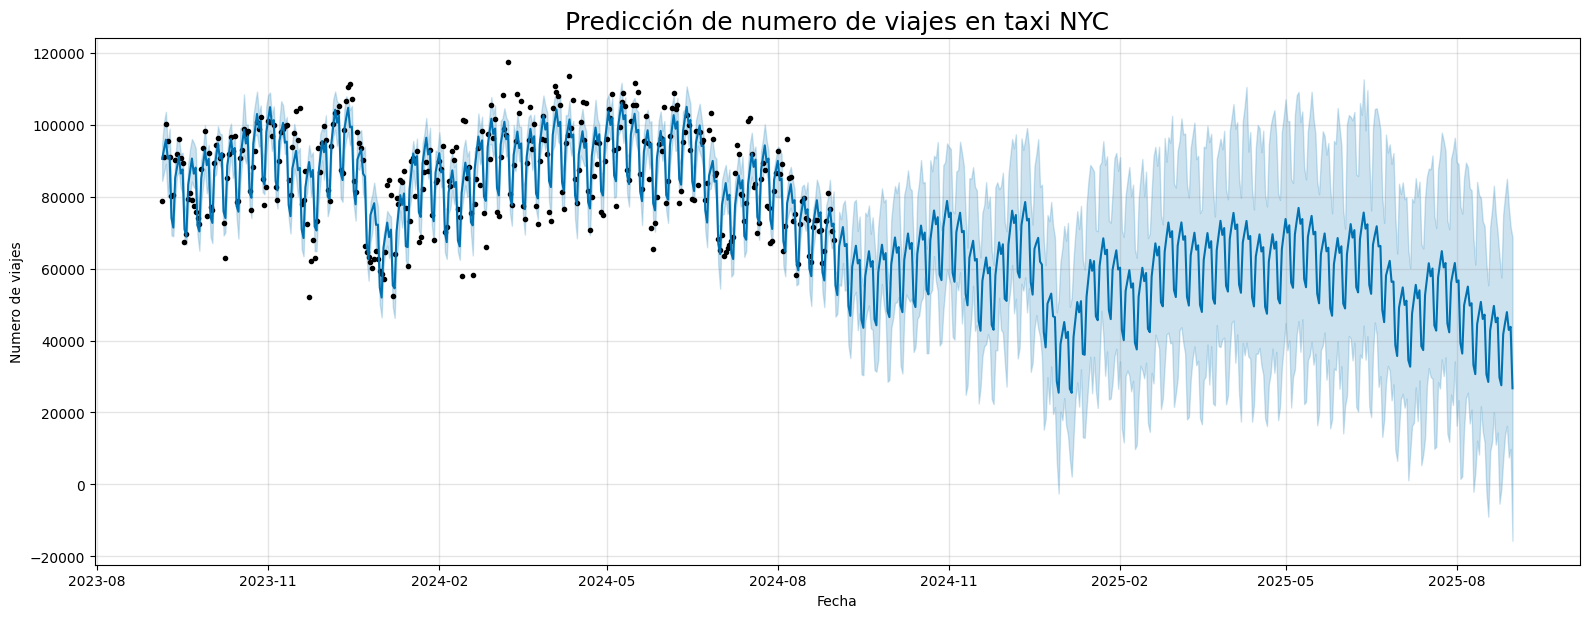

In [ ]:
# plot forecasts

prophet_1.plot(forecast_1, xlabel='Fecha', ylabel='Numero de viajes', figsize = (16,6))
plt.title('Predicción de numero de viajes en taxi NYC', fontsize = 18)
plt.show()

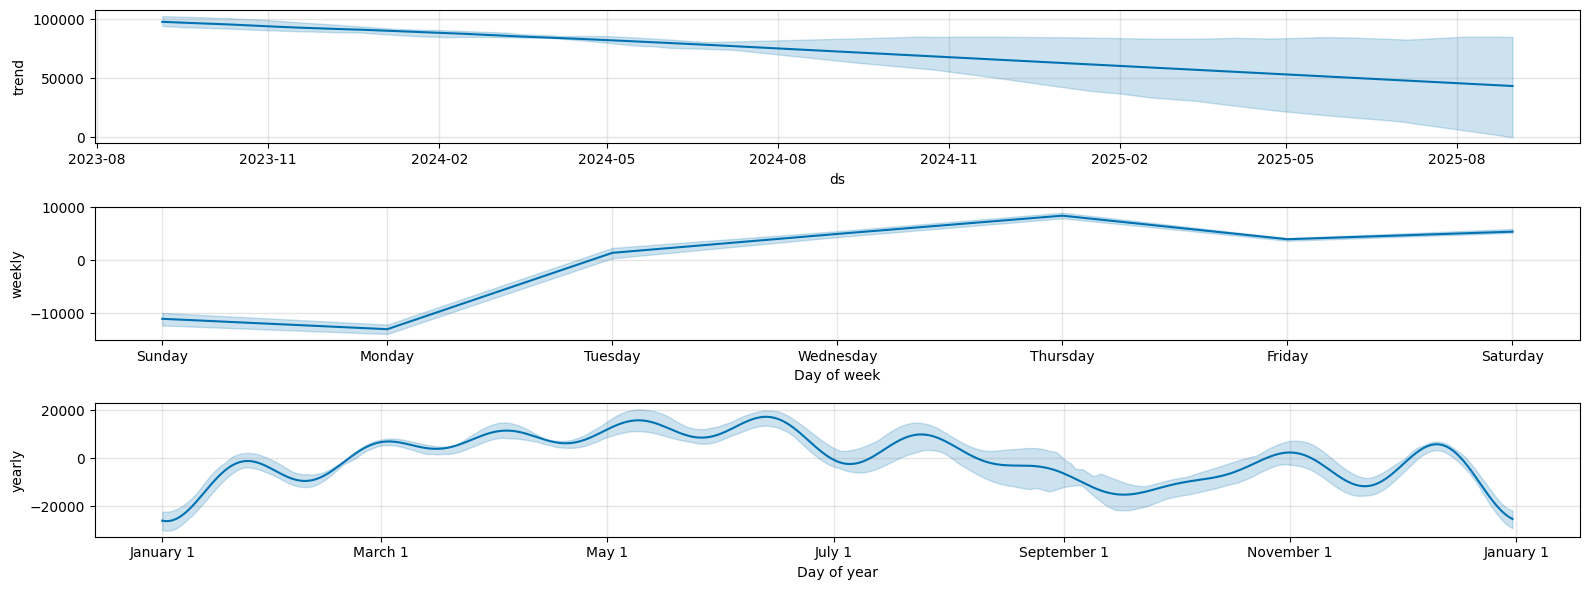

In [ ]:
# Ploteamos los componentes de nuestra serie de tiempo

components = prophet_1.plot_components(forecast_1, figsize=(16,6))

#### Evaluacion

In [ ]:
df_cv_1 = cross_validation(prophet_1, initial = '120 days', horizon = '120 days')

INFO:prophet:Making 3 forecasts with cutoffs between 2024-01-04 00:00:00 and 2024-05-03 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ke_jo2c/f56o5yaf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ke_jo2c/j2mfb7f5.json
21:42:19 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=43080', 'data', 'file=/tmp/tmp8ke_jo2c/f56o5yaf.json', 'init=/tmp/tmp8ke_jo2c/j2mfb7f5.json', 'output', 'file=/tmp/tmp8ke_jo2c/prophet_modelwsdh7z8p/prophet_model-20241113214219_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=43080', 'data', 'file=/tmp/tmp8ke_jo2c/f56o5yaf.json', 'init=/tmp/tmp8ke_jo2c/j2mfb7f5.json', 'output', 'file=/tmp/tmp8ke_jo2c/prophet_modelwsdh7z8p/prophet_model-20241113214219_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

21:42:19 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=43080', 'data', 'file=/tmp/tmp8ke_jo2c/f56o5yaf.json', 'init=/tmp/tmp8ke_jo2c/j2mfb7f5.json', 'output', 'file=/tmp/tmp8ke_jo2c/prophet_modelwsdh7z8p/prophet_model-20241113214219_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp8ke_jo2c/prophet_modelwsdh7z8p/prophet_model-20241113214219_1.csv
 console_msgs (if any):
	/tmp/tmp8ke_jo2c/prophet_modelwsdh7z8p/prophet_model-20241113214219_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ke_jo2c/r17an2cw.json
21:42:19 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=8019', 'data', 'file=/tmp/tmp8ke_jo2c/v401ucvj.json', 'init=/tmp/tmp8ke_jo2c/r17an2cw.json', 'output', 'file=/tmp/tmp8ke_jo2c/prophet_model2uzbpyjv/prophet_model-20241113214220_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=8019', 'data', 'file=/tmp/tmp8ke_jo2c/v401ucvj.json', 'init=/tmp/tmp8ke_jo2c/r17an2cw.json', 'output', 'file=/tmp/tmp8ke_jo2c/prophet_model2uzbpyjv/prophet_model-20241113214220_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:

21:42:20 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=8019', 'data', 'file=/tmp/tmp8ke_jo2c/v401ucvj.json', 'init=/tmp/tmp8ke_jo2c/r17an2cw.json', 'output', 'file=/tmp/tmp8ke_jo2c/prophet_model2uzbpyjv/prophet_model-20241113214220_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp8ke_jo2c/prophet_model2uzbpyjv/prophet_model-20241113214220_1.csv
 console_msgs (if any):
	/tmp/tmp8ke_jo2c/prophet_model2uzbpyjv/prophet_model-20241113214220_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)
 

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ke_jo2c/hrq7pogt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ke_jo2c/rqeczo3p.json
21:42:20 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=37949', 'data', 'file=/tmp/tmp8ke_jo2c/hrq7pogt.json', 'init=/tmp/tmp8ke_jo2c/rqeczo3p.json', 'output', 'file=/tmp/tmp8ke_jo2c/prophet_modelo09_p963/prophet_model-20241113214220_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=37949', 'data', 'file=/tmp/tmp8ke_jo2c/hrq7pogt.json', 'init=/tmp/tmp8ke_jo2c/rqeczo3p.json', 'output', 'file=/tmp/tmp8ke_jo2c/prophet_modelo09_p963/prophet_model-20241113214220_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

21:42:21 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=37949', 'data', 'file=/tmp/tmp8ke_jo2c/hrq7pogt.json', 'init=/tmp/tmp8ke_jo2c/rqeczo3p.json', 'output', 'file=/tmp/tmp8ke_jo2c/prophet_modelo09_p963/prophet_model-20241113214220_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp8ke_jo2c/prophet_modelo09_p963/prophet_model-20241113214220_1.csv
 console_msgs (if any):
	/tmp/tmp8ke_jo2c/prophet_modelo09_p963/prophet_model-20241113214220_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


In [ ]:
df_cv_1


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2024-01-05,79382.038745,75218.612509,91047.267871,84757.0,2024-01-04
1,2024-01-06,84842.913809,63263.518613,99473.012057,80497.0,2024-01-04
2,2024-01-07,79484.520862,60083.038528,98119.934813,52261.0,2024-01-04
3,2024-01-08,86088.642865,59902.302727,112147.185516,64069.0,2024-01-04
4,2024-01-09,106080.016842,67331.344330,138541.019292,79631.0,2024-01-04
...,...,...,...,...,...,...
355,2024-08-27,79702.712582,46792.508482,124239.503736,73266.0,2024-05-03
356,2024-08-28,92318.806514,51957.819313,137496.114574,81088.0,2024-05-03
357,2024-08-29,103162.735940,70716.471539,132276.575562,76483.0,2024-05-03
358,2024-08-30,102399.938588,82933.066055,123755.746866,70549.0,2024-05-03


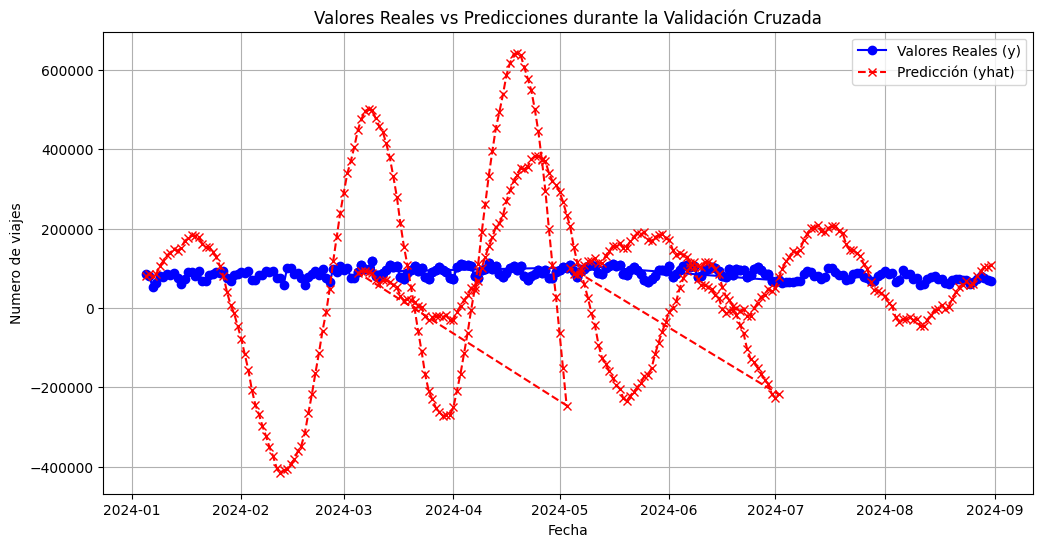

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_cv_1['ds'], df_cv_1['y'], label='Valores Reales (y)', color='blue', marker='o')
plt.plot(df_cv_1['ds'], df_cv_1['yhat'], label='Predicción (yhat)', color='red', linestyle='--', marker='x')

plt.xlabel('Fecha')
plt.ylabel('Numero de viajes')
plt.title('Valores Reales vs Predicciones durante la Validación Cruzada')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df_p_1 = performance_metrics(df_cv_1)
df_p_1.describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,109,1.090000e+02,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,66 days 00:00:00,4.117288e+10,191618.967135,152144.762681,1.744174,1.323251,1.178747,0.808614
std,31 days 14:37:49.241158121,2.288167e+10,67054.476864,49724.226302,0.575955,0.472882,0.278181,0.144354
min,12 days 00:00:00,1.345334e+09,36678.791279,28247.462840,0.338880,0.256123,0.286944,0.388889
25%,39 days 00:00:00,2.335485e+10,152822.939047,116280.796556,1.337817,1.030346,1.043810,0.750000
50%,66 days 00:00:00,4.386612e+10,209442.395586,169381.083311,1.912971,1.247435,1.240949,0.833333
75%,93 days 00:00:00,5.292306e+10,230050.127967,185976.922054,2.142582,1.639042,1.363751,0.916667
max,120 days 00:00:00,8.389732e+10,289650.348356,224698.056872,2.706273,2.273030,1.619453,1.000000


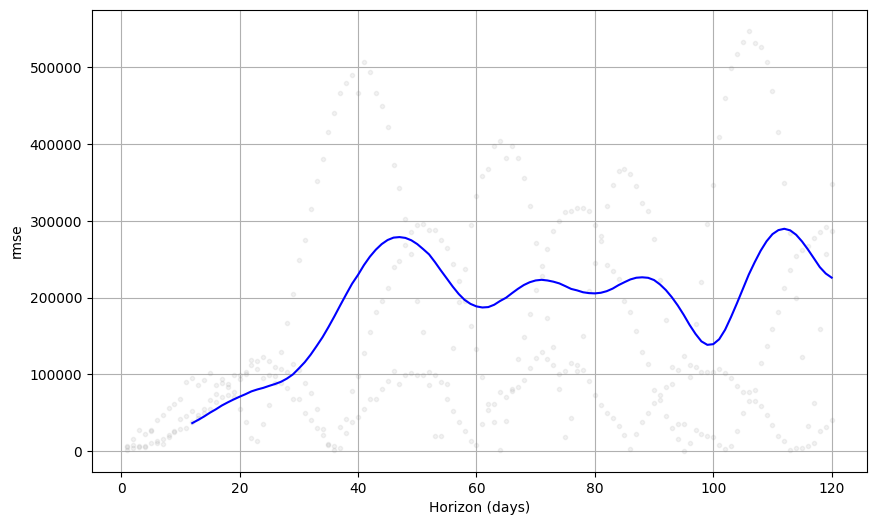

In [ ]:
fig = plot_cross_validation_metric(df_cv_1, metric='rmse')

In [ ]:
print('El RMSE es:', df_p_1.rmse.mean())

El RMSE es: 191618.96713510994


In [ ]:
df_p_1 = performance_metrics(df_cv_1, rolling_window = 1)
df_p_1

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,120 days,3.942023e+10,198545.275153,146575.061969,1.684395,1.121194,1.135321,0.805556


### Semanal

In [ ]:
semanal

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-17,782870,959974.79,12179688.56,7.395936e+06,606553.00
2023-09-24,341409,416200.11,5594414.93,3.412822e+06,536233.00
2023-10-01,771602,944911.79,11838656.66,7.086461e+06,595336.00
2023-10-08,801099,981060.43,12204336.29,7.349261e+06,611780.00
2023-10-15,792958,965088.12,12042382.50,7.287548e+06,604932.00
2023-10-22,833690,1025976.55,12831777.30,7.789044e+06,638659.00
2023-10-29,838860,1030375.53,12954809.18,7.852571e+06,643674.00
2023-11-05,841134,1022938.51,12805134.84,7.717200e+06,641573.00
2023-11-12,842513,1034821.18,12925628.45,7.903845e+06,649886.00


In [ ]:
semanal_p = semanal['n_trips']

In [ ]:
semanal_p

,n_trips
pickup_datetime,
2023-09-17,606553.00
2023-09-24,536233.00
2023-10-01,595336.00
2023-10-08,611780.00
2023-10-15,604932.00
2023-10-22,638659.00
2023-10-29,643674.00
2023-11-05,641573.00
2023-11-12,649886.00


In [ ]:
semanal_p = semanal_p.reset_index()

In [ ]:
semanal_p.rename(columns= {'pickup_datetime': 'ds', 'n_trips' : 'y'}, inplace = True)
semanal_p

,ds,y
0,2023-09-17,606553.00
1,2023-09-24,536233.00
2,2023-10-01,595336.00
3,2023-10-08,611780.00
4,2023-10-15,604932.00
5,2023-10-22,638659.00
6,2023-10-29,643674.00
7,2023-11-05,641573.00
8,2023-11-12,649886.00
9,2023-11-19,653709.00


In [ ]:
# Instanciamos un modelo de Prophet

prophet_2 = Prophet(yearly_seasonality= True, weekly_seasonality= True,uncertainty_samples = 100, mcmc_samples=100, interval_width= 0.8)
#daily_seasonality=False,    # Desactivar estacionalidad diaria
 #   yearly_seasonality=True,    # Activar estacionalidad anual para capturar patrones del año completo
  #  weekly_seasonality=True,    # Activar estacionalidad semanal si hay patrones semanales
   # uncertainty_samples=100,    # Ajustar número de muestras para análisis de incertidumbre
    #interval_width=0.8
# Entrenamos el modelo
prophet_2.fit(semanal_p)

# Construimos un dataframe con los x valores futuros que querámos predecir. 52 semanas
build_forecast = prophet_2.make_future_dataframe(periods=52, freq='W') #

# Predecimos
forecast_2 = prophet_2.predict(build_forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/4nxrf64y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/go__phon.json
03:35:20 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=31024', 'data', 'file=/tmp/tmpxj1868mv/4nxrf64y.json', 'init=/tmp/tmpxj1868mv/go__phon.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_modelvwzdhbdv/prophet_model-20241114033520_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=31024', 'data', 'file=/tmp/tmpxj1868mv/4nxrf64y.json', 'init=/tmp/tmpxj1868mv/go__phon.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_modelvwzdhbdv/prophet_model-20241114033520_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

03:35:24 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=31024', 'data', 'file=/tmp/tmpxj1868mv/4nxrf64y.json', 'init=/tmp/tmpxj1868mv/go__phon.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_modelvwzdhbdv/prophet_model-20241114033520_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpxj1868mv/prophet_modelvwzdhbdv/prophet_model-20241114033520_1.csv
 console_msgs (if any):
	/tmp/tmpxj1868mv/prophet_modelvwzdhbdv/prophet_model-20241114033520_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 50
    num_warmup = 50
    save_warmup = 0 (Default)
    thin = 1 (Default)


In [ ]:
forecast_2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-09-17,2.807310e+04,5.367712e+05,6.438398e+05,-4.530911e+06,6.756157e+06,568138.708071,-6.151405e+06,5.145008e+06,303763.481653,-7.195521e+06,4.905240e+06,264375.226418,-7.424077e+05,1.407347e+06,0.0,0.0,0.0,5.962118e+05
1,2023-09-24,4.141002e+04,5.160775e+05,6.111117e+05,-4.495144e+06,6.841512e+06,521838.112435,-6.252505e+06,5.099196e+06,303763.481652,-7.195521e+06,4.905240e+06,218074.630783,-8.022236e+05,1.306252e+06,0.0,0.0,0.0,5.632481e+05
2,2023-10-01,5.468134e+04,5.280240e+05,6.201055e+05,-4.459212e+06,6.925754e+06,519232.998445,-6.352736e+06,5.055144e+06,303763.481657,-7.195521e+06,4.905240e+06,215469.516788,-7.395481e+05,1.239440e+06,0.0,0.0,0.0,5.739143e+05
3,2023-10-08,6.795265e+04,5.570481e+05,6.513373e+05,-4.449958e+06,7.009996e+06,539252.590474,-6.385090e+06,5.065011e+06,303763.481653,-7.195521e+06,4.905240e+06,235489.108821,-6.610807e+05,1.218083e+06,0.0,0.0,0.0,6.072052e+05
4,2023-10-15,8.119364e+04,5.811180e+05,6.829118e+05,-4.450533e+06,7.092759e+06,547192.889220,-6.435087e+06,5.067842e+06,303763.481658,-7.195521e+06,4.905240e+06,243429.407562,-6.120282e+05,1.179511e+06,0.0,0.0,0.0,6.283865e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2025-07-06,1.193541e+06,-1.100466e+06,3.738224e+06,-4.966738e+06,1.120610e+07,37468.240325,-7.932684e+06,4.936659e+06,303763.481651,-7.195521e+06,4.905240e+06,-266295.241326,-1.183182e+06,5.832977e+05,0.0,0.0,0.0,1.231010e+06
95,2025-07-13,1.205722e+06,-1.084967e+06,3.775945e+06,-5.002446e+06,1.128046e+07,22717.484559,-7.984284e+06,4.929297e+06,303763.481653,-7.195521e+06,4.905240e+06,-281045.997093,-1.232689e+06,5.885600e+05,0.0,0.0,0.0,1.228440e+06
96,2025-07-20,1.217904e+06,-1.056287e+06,3.777755e+06,-5.038257e+06,1.135483e+07,9132.311360,-8.048608e+06,4.928861e+06,303763.481647,-7.195521e+06,4.905240e+06,-294631.170287,-1.308162e+06,6.193587e+05,0.0,0.0,0.0,1.227036e+06
97,2025-07-27,1.230085e+06,-1.042142e+06,3.728788e+06,-5.073981e+06,1.142987e+07,-21190.022623,-8.152029e+06,4.919014e+06,303763.481651,-7.195521e+06,4.905240e+06,-324953.504275,-1.399631e+06,6.725659e+05,0.0,0.0,0.0,1.208895e+06


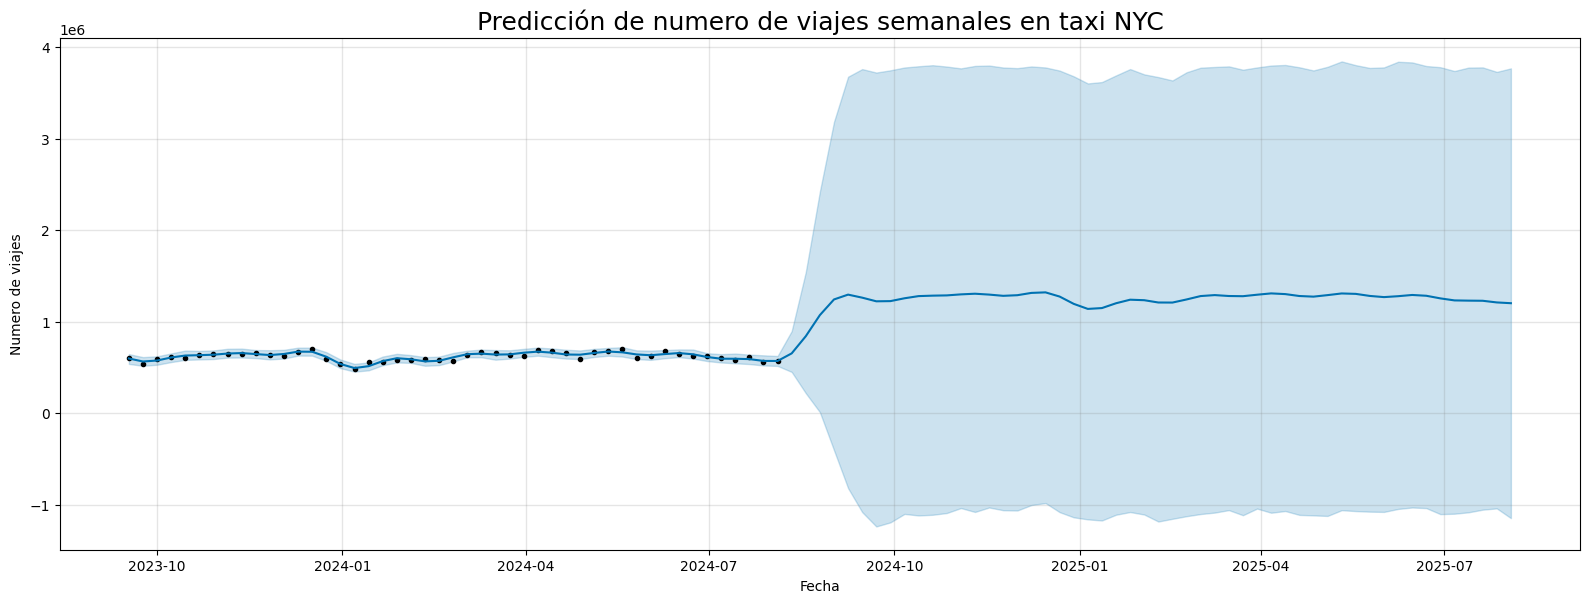

In [ ]:
# plot forecasts

prophet_2.plot(forecast_2, xlabel='Fecha', ylabel='Numero de viajes', figsize = (16,6))
plt.title('Predicción de numero de viajes semanales en taxi NYC', fontsize = 18)
plt.show()

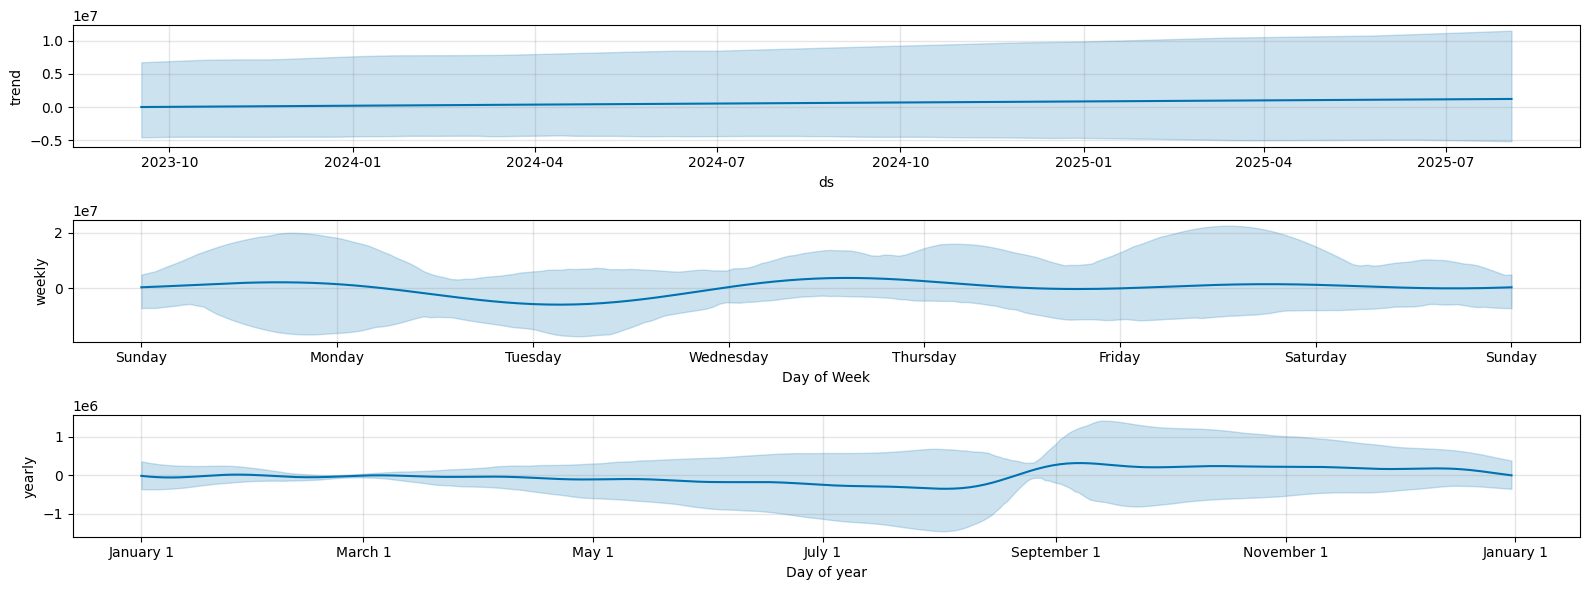

In [ ]:
# Ploteamos los componentes de nuestra serie de tiempo

components = prophet_2.plot_components(forecast_2, figsize=(16,6))

#### Evaluacion

In [ ]:
df_cv_2 = cross_validation(prophet_2, initial = '60 days', horizon = '60 days')

INFO:prophet:Making 7 forecasts with cutoffs between 2023-12-08 00:00:00 and 2024-06-05 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/gmudbok6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/0bllt44l.json
03:35:29 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=25173', 'data', 'file=/tmp/tmpxj1868mv/gmudbok6.json', 'init=/tmp/tmpxj1868mv/0bllt44l.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_modelhzvx3by0/prophet_model-20241114033529_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=25173', 'data', 'file=/tmp/tmpxj1868mv/gmudbok6.json', 'init=/tmp/tmpxj1868mv/0bllt44l.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_modelhzvx3by0/prophet_model-20241114033529_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

03:35:32 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=25173', 'data', 'file=/tmp/tmpxj1868mv/gmudbok6.json', 'init=/tmp/tmpxj1868mv/0bllt44l.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_modelhzvx3by0/prophet_model-20241114033529_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpxj1868mv/prophet_modelhzvx3by0/prophet_model-20241114033529_1.csv
 console_msgs (if any):
	/tmp/tmpxj1868mv/prophet_modelhzvx3by0/prophet_model-20241114033529_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 50
    num_warmup = 50
    save_warmup = 0 (Default)
    thin = 1 (Default)


INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/54vejz0l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/8pgl0v19.json
03:35:32 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=82548', 'data', 'file=/tmp/tmpxj1868mv/54vejz0l.json', 'init=/tmp/tmpxj1868mv/8pgl0v19.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_model03u7tkpp/prophet_model-20241114033532_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=82548', 'data', 'file=/tmp/tmpxj1868mv/54vejz0l.json', 'init=/tmp/tmpxj1868mv/8pgl0v19.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_model03u7tkpp/prophet_model-20241114033532_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

03:35:35 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=82548', 'data', 'file=/tmp/tmpxj1868mv/54vejz0l.json', 'init=/tmp/tmpxj1868mv/8pgl0v19.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_model03u7tkpp/prophet_model-20241114033532_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpxj1868mv/prophet_model03u7tkpp/prophet_model-20241114033532_1.csv
 console_msgs (if any):
	/tmp/tmpxj1868mv/prophet_model03u7tkpp/prophet_model-20241114033532_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 50
    num_warmup = 50
    save_warmup = 0 (Default)
    thin = 1 (Default)


INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/mto1m06e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/4k2_j9ii.json
03:35:36 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=62505', 'data', 'file=/tmp/tmpxj1868mv/mto1m06e.json', 'init=/tmp/tmpxj1868mv/4k2_j9ii.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_modelut0h1pha/prophet_model-20241114033536_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=62505', 'data', 'file=/tmp/tmpxj1868mv/mto1m06e.json', 'init=/tmp/tmpxj1868mv/4k2_j9ii.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_modelut0h1pha/prophet_model-20241114033536_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

03:35:41 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=62505', 'data', 'file=/tmp/tmpxj1868mv/mto1m06e.json', 'init=/tmp/tmpxj1868mv/4k2_j9ii.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_modelut0h1pha/prophet_model-20241114033536_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpxj1868mv/prophet_modelut0h1pha/prophet_model-20241114033536_1.csv
 console_msgs (if any):
	/tmp/tmpxj1868mv/prophet_modelut0h1pha/prophet_model-20241114033536_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 50
    num_warmup = 50
    save_warmup = 0 (Default)
    thin = 1 (Default)


INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/ssbo8r8q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/cxf4b6g_.json
03:35:41 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=47342', 'data', 'file=/tmp/tmpxj1868mv/ssbo8r8q.json', 'init=/tmp/tmpxj1868mv/cxf4b6g_.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_modelygtdfkjd/prophet_model-20241114033541_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=47342', 'data', 'file=/tmp/tmpxj1868mv/ssbo8r8q.json', 'init=/tmp/tmpxj1868mv/cxf4b6g_.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_modelygtdfkjd/prophet_model-20241114033541_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

03:35:45 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=47342', 'data', 'file=/tmp/tmpxj1868mv/ssbo8r8q.json', 'init=/tmp/tmpxj1868mv/cxf4b6g_.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_modelygtdfkjd/prophet_model-20241114033541_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpxj1868mv/prophet_modelygtdfkjd/prophet_model-20241114033541_1.csv
 console_msgs (if any):
	/tmp/tmpxj1868mv/prophet_modelygtdfkjd/prophet_model-20241114033541_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 50
    num_warmup = 50
    save_warmup = 0 (Default)
    thin = 1 (Default)


INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/kxbdv5gl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/n_nm6lku.json
03:35:45 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=96035', 'data', 'file=/tmp/tmpxj1868mv/kxbdv5gl.json', 'init=/tmp/tmpxj1868mv/n_nm6lku.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_model8zein241/prophet_model-20241114033546_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=96035', 'data', 'file=/tmp/tmpxj1868mv/kxbdv5gl.json', 'init=/tmp/tmpxj1868mv/n_nm6lku.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_model8zein241/prophet_model-20241114033546_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

03:35:49 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=96035', 'data', 'file=/tmp/tmpxj1868mv/kxbdv5gl.json', 'init=/tmp/tmpxj1868mv/n_nm6lku.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_model8zein241/prophet_model-20241114033546_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpxj1868mv/prophet_model8zein241/prophet_model-20241114033546_1.csv
 console_msgs (if any):
	/tmp/tmpxj1868mv/prophet_model8zein241/prophet_model-20241114033546_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 50
    num_warmup = 50
    save_warmup = 0 (Default)
    thin = 1 (Default)


DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/vu2fjbeb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/2ufn6bqa.json
03:35:50 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=5769', 'data', 'file=/tmp/tmpxj1868mv/vu2fjbeb.json', 'init=/tmp/tmpxj1868mv/2ufn6bqa.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_model2df49m55/prophet_model-20241114033550_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=5769', 'data', 'file=/tmp/tmpxj1868mv/vu2fjbeb.json', 'init=/tmp/tmpxj1868mv/2ufn6bqa.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_model2df49m55/prophet_model-20241114033550_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:

03:35:55 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=5769', 'data', 'file=/tmp/tmpxj1868mv/vu2fjbeb.json', 'init=/tmp/tmpxj1868mv/2ufn6bqa.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_model2df49m55/prophet_model-20241114033550_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpxj1868mv/prophet_model2df49m55/prophet_model-20241114033550_1.csv
 console_msgs (if any):
	/tmp/tmpxj1868mv/prophet_model2df49m55/prophet_model-20241114033550_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 50
    num_warmup = 50
    save_warmup = 0 (Default)
    thin = 1 (Default)
 

DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/mambtkhs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxj1868mv/uom2g009.json
03:35:56 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=55512', 'data', 'file=/tmp/tmpxj1868mv/mambtkhs.json', 'init=/tmp/tmpxj1868mv/uom2g009.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_model9vyd6e0o/prophet_model-20241114033556_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=55512', 'data', 'file=/tmp/tmpxj1868mv/mambtkhs.json', 'init=/tmp/tmpxj1868mv/uom2g009.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_model9vyd6e0o/prophet_model-20241114033556_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

03:36:00 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=55512', 'data', 'file=/tmp/tmpxj1868mv/mambtkhs.json', 'init=/tmp/tmpxj1868mv/uom2g009.json', 'output', 'file=/tmp/tmpxj1868mv/prophet_model9vyd6e0o/prophet_model-20241114033556_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpxj1868mv/prophet_model9vyd6e0o/prophet_model-20241114033556_1.csv
 console_msgs (if any):
	/tmp/tmpxj1868mv/prophet_model9vyd6e0o/prophet_model-20241114033556_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 50
    num_warmup = 50
    save_warmup = 0 (Default)
    thin = 1 (Default)


In [ ]:
df_cv_2


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-12-10,1.119628e+06,4.358590e+05,2.506934e+06,672453.00,2023-12-08
1,2023-12-17,2.799445e+06,-4.960840e+04,8.047917e+06,704894.00,2023-12-08
2,2023-12-24,5.582119e+06,-6.455134e+05,1.716774e+07,588744.50,2023-12-08
3,2023-12-31,8.071140e+06,-9.220728e+05,2.466684e+07,534932.75,2023-12-08
4,2024-01-07,8.407314e+06,-8.353895e+05,2.115296e+07,481121.00,2023-12-08
5,2024-01-14,6.163644e+06,-3.672920e+06,1.694988e+07,554333.00,2023-12-08
6,2024-01-21,3.337902e+06,-1.258812e+07,1.612289e+07,554947.00,2023-12-08
7,2024-01-28,2.942460e+06,-1.433286e+07,2.262072e+07,582275.00,2023-12-08
8,2024-02-04,6.164684e+06,-1.567810e+07,3.415612e+07,578652.00,2023-12-08
9,2024-01-14,-3.765750e+05,-6.498070e+05,-9.531329e+04,554333.00,2024-01-07


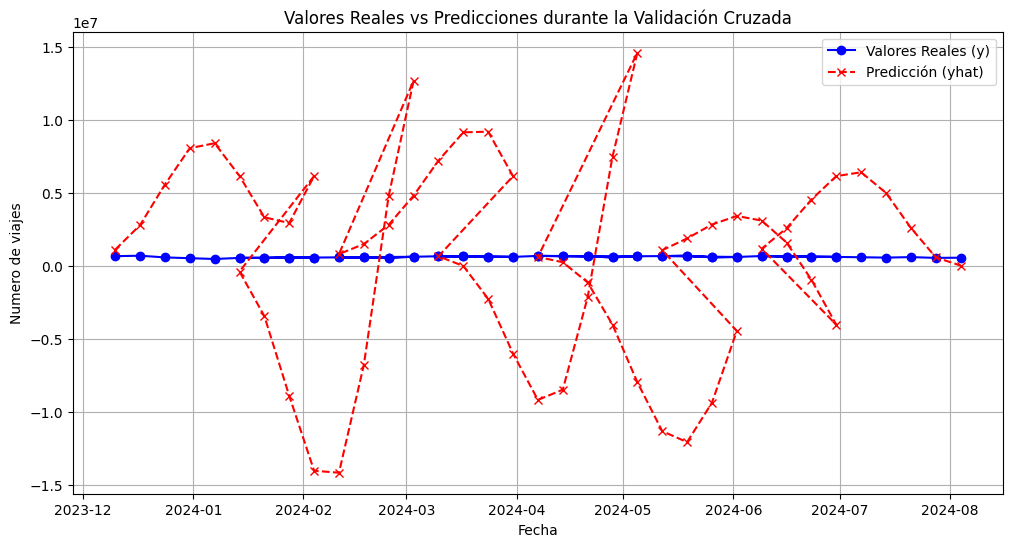

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_cv_2['ds'], df_cv_2['y'], label='Valores Reales (y)', color='blue', marker='o')
plt.plot(df_cv_2['ds'], df_cv_2['yhat'], label='Predicción (yhat)', color='red', linestyle='--', marker='x')

plt.xlabel('Fecha')
plt.ylabel('Numero de viajes')
plt.title('Valores Reales vs Predicciones durante la Validación Cruzada')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df_p_2 = performance_metrics(df_cv_2)
df_p_2.describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,55,5.500000e+01,5.500000e+01,5.500000e+01,55.000000,55.000000,55.000000,55.000000
mean,33 days 00:00:00,4.019998e+13,5.718061e+06,5.013094e+06,8.162114,7.380654,1.562472,0.787879
std,16 days 00:29:58.829648400,2.860596e+13,2.764547e+06,2.501251e+06,4.060610,3.981180,0.313244,0.155339
min,6 days 00:00:00,1.119302e+11,3.345598e+05,2.754490e+05,0.413780,0.485391,0.321408,0.500000
25%,19 days 12:00:00,1.182091e+13,3.437868e+06,3.213805e+06,5.328642,4.642903,1.477018,0.666667
50%,33 days 00:00:00,4.102110e+13,6.404772e+06,5.252938e+06,8.754054,8.342469,1.668365,0.833333
75%,46 days 12:00:00,6.312075e+13,7.944316e+06,6.926612e+06,11.093428,10.054040,1.739567,0.916667
max,60 days 00:00:00,9.470274e+13,9.731533e+06,9.069740e+06,14.731252,13.580200,1.850666,1.000000


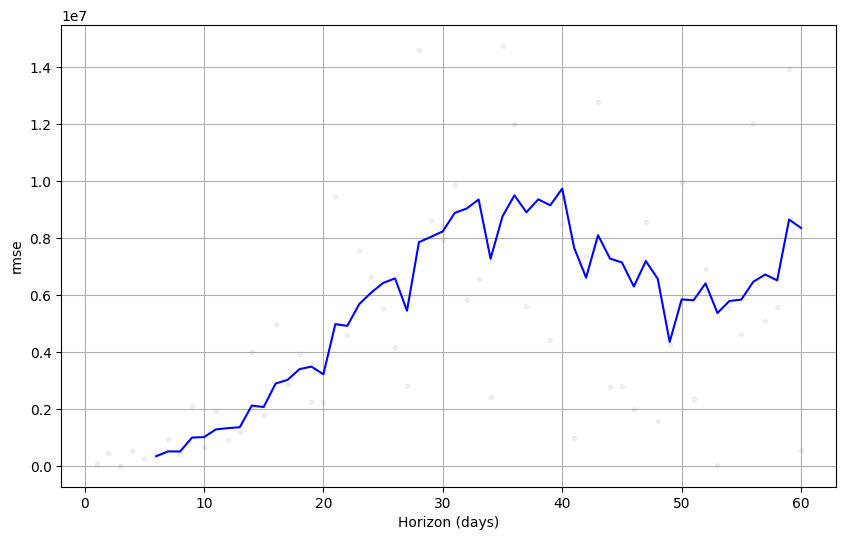

In [ ]:
fig = plot_cross_validation_metric(df_cv_2, metric='rmse')

In [ ]:
df_p = performance_metrics(df_cv_2, rolling_window = 1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,60 days,3.982314e+13,6.310558e+06,4.875347e+06,7.919692,7.30636,1.518673,0.8


In [ ]:
print('La cobertura es:', df_p_2.coverage.mean())

La cobertura es: 0.7878787878787878


In [ ]:
print('El MAE es:', df_p_2.mae.mean())

El MAE es: 5013093.804862897


### Mensual

In [ ]:
mensual

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-30,2834965,3460189.95,43351361.13,2.606321e+07,2179200
2023-10-31,3576133,4382900.21,54676872.61,3.301915e+07,2736389
2023-11-30,3427883,4139501.57,51979545.55,3.135258e+07,2616757
2023-12-31,3541070,4167204.54,51955671.11,3.122333e+07,2625768
2024-01-31,3104773,3883527.49,46044469.28,2.626918e+07,2409342
2024-02-29,3124501,3959766.71,47253940.40,2.747364e+07,2448952
2024-03-31,3628203,4703052.88,55237790.42,3.265720e+07,2858661
2024-04-30,3513134,4646128.88,54112655.33,3.226751e+07,2777362
2024-05-31,3665269,4793006.98,57431400.26,3.453748e+07,2899539


In [ ]:
mensual_p = mensual['n_trips']

In [ ]:
mensual_p

,n_trips
pickup_datetime,
2023-09-30,2179200
2023-10-31,2736389
2023-11-30,2616757
2023-12-31,2625768
2024-01-31,2409342
2024-02-29,2448952
2024-03-31,2858661
2024-04-30,2777362
2024-05-31,2899539


In [ ]:
mensual_p = mensual_p.reset_index()

In [ ]:
mensual_p.rename(columns= {'pickup_datetime': 'ds', 'n_trips' : 'y'}, inplace = True)
mensual_p

,ds,y
0,2023-09-30,2179200
1,2023-10-31,2736389
2,2023-11-30,2616757
3,2023-12-31,2625768
4,2024-01-31,2409342
5,2024-02-29,2448952
6,2024-03-31,2858661
7,2024-04-30,2777362
8,2024-05-31,2899539
9,2024-06-30,2767032


In [ ]:
# Instanciamos un modelo de Prophet

prophet_3 = Prophet(yearly_seasonality= True, daily_seasonality=True, weekly_seasonality=True, uncertainty_samples = 20, mcmc_samples=20, interval_width= 0.5)

# Entrenamos el modelo
prophet_3.fit(mensual_p)

# Construimos un dataframe con los x valores futuros que querámos predecir. 12 meses.
build_forecast = prophet_3.make_future_dataframe(periods=12, freq='M') #

# Predecimos
forecast_3 = prophet_3.predict(build_forecast)

INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/cdh5ru5o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/4ny3gf1j.json
19:26:04 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=72486', 'data', 'file=/tmp/tmp_62cw8sc/cdh5ru5o.json', 'init=/tmp/tmp_62cw8sc/4ny3gf1j.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modeljryp_st3/prophet_model-20241113192604_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=72486', 'data', 'file=/tmp/tmp_62cw8sc/cdh5ru5o.json', 'init=/tmp/tmp_62cw8sc/4ny3gf1j.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modeljryp_st3/prophet_model-20241113192604_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

19:26:05 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=72486', 'data', 'file=/tmp/tmp_62cw8sc/cdh5ru5o.json', 'init=/tmp/tmp_62cw8sc/4ny3gf1j.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modeljryp_st3/prophet_model-20241113192604_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_62cw8sc/prophet_modeljryp_st3/prophet_model-20241113192604_1.csv
 console_msgs (if any):
	/tmp/tmp_62cw8sc/prophet_modeljryp_st3/prophet_model-20241113192604_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


In [ ]:
forecast_3

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-09-30,1.342651e+06,1.323945e+06,2.427801e+06,-9.081102e+06,7.251812e+06,5.172377e+05,-5.263285e+06,1.091745e+07,6.379812e+06,...,-5.520114e+06,-1.861408e+07,2.159054e+06,-3.424605e+05,-7.844039e+06,1.242268e+07,0.0,0.0,0.0,1.859889e+06
1,2023-10-31,3.915335e+05,2.208702e+06,3.415682e+06,-9.916500e+06,6.358589e+06,2.379299e+06,-3.552791e+06,1.278953e+07,6.379812e+06,...,-1.997938e+06,-1.621415e+07,1.499744e+07,-2.002575e+06,-1.466589e+07,1.073488e+07,0.0,0.0,0.0,2.770832e+06
2,2023-11-30,-5.310349e+05,2.372517e+06,2.867642e+06,-1.072889e+07,5.418325e+06,3.226051e+06,-2.772165e+06,1.312443e+07,6.379812e+06,...,-1.011588e+06,-1.142206e+07,9.198113e+06,-2.142174e+06,-1.234329e+07,1.000100e+07,0.0,0.0,0.0,2.695016e+06
3,2023-12-31,-1.484762e+06,1.997660e+06,3.008287e+06,-1.124199e+07,4.333827e+06,4.446288e+06,-1.453014e+06,1.365740e+07,6.379812e+06,...,-7.877941e+06,-2.276698e+07,7.463983e+06,5.944416e+06,-4.005762e+06,1.691057e+07,0.0,0.0,0.0,2.961526e+06
4,2024-01-31,-2.441059e+06,1.924717e+06,2.862023e+06,-1.173690e+07,3.247413e+06,4.796048e+06,-1.233250e+06,1.381146e+07,6.379812e+06,...,7.619968e+06,-1.347402e+07,1.926899e+07,-9.203733e+06,-2.177022e+07,1.246850e+07,0.0,0.0,0.0,2.354989e+06
5,2024-02-29,-3.336677e+06,2.071463e+06,3.167328e+06,-1.217026e+07,2.232023e+06,5.884936e+06,1.810775e+05,1.457752e+07,6.379812e+06,...,-1.011588e+06,-1.142206e+07,9.198113e+06,5.167108e+05,-1.181141e+07,1.167868e+07,0.0,0.0,0.0,2.548258e+06
6,2024-03-31,-4.294226e+06,2.441724e+06,3.485266e+06,-1.262556e+07,1.125881e+06,6.992116e+06,1.384992e+06,1.561393e+07,6.379812e+06,...,-7.877941e+06,-2.276698e+07,7.463983e+06,8.490244e+06,-2.486230e+06,2.106159e+07,0.0,0.0,0.0,2.697890e+06
7,2024-04-30,-5.219738e+06,2.386833e+06,3.264107e+06,-1.304388e+07,1.851456e+05,7.972300e+06,2.357881e+06,1.585574e+07,6.379812e+06,...,-1.997938e+06,-1.621415e+07,1.499744e+07,3.590425e+06,-6.816651e+06,1.785290e+07,0.0,0.0,0.0,2.752561e+06
8,2024-05-31,-6.173287e+06,2.555313e+06,3.325327e+06,-1.346349e+07,-6.784132e+05,9.109394e+06,3.957120e+06,1.608908e+07,6.379812e+06,...,2.024824e+07,3.664831e+06,3.625026e+07,-1.751866e+07,-2.654145e+07,-1.012582e+07,0.0,0.0,0.0,2.936107e+06
9,2024-06-30,-7.091271e+06,2.389640e+06,3.393763e+06,-1.430059e+07,-1.637728e+06,1.037333e+07,4.384673e+06,1.823497e+07,6.379812e+06,...,-7.877941e+06,-2.276698e+07,7.463983e+06,1.187146e+07,1.177397e+06,2.232579e+07,0.0,0.0,0.0,3.282062e+06


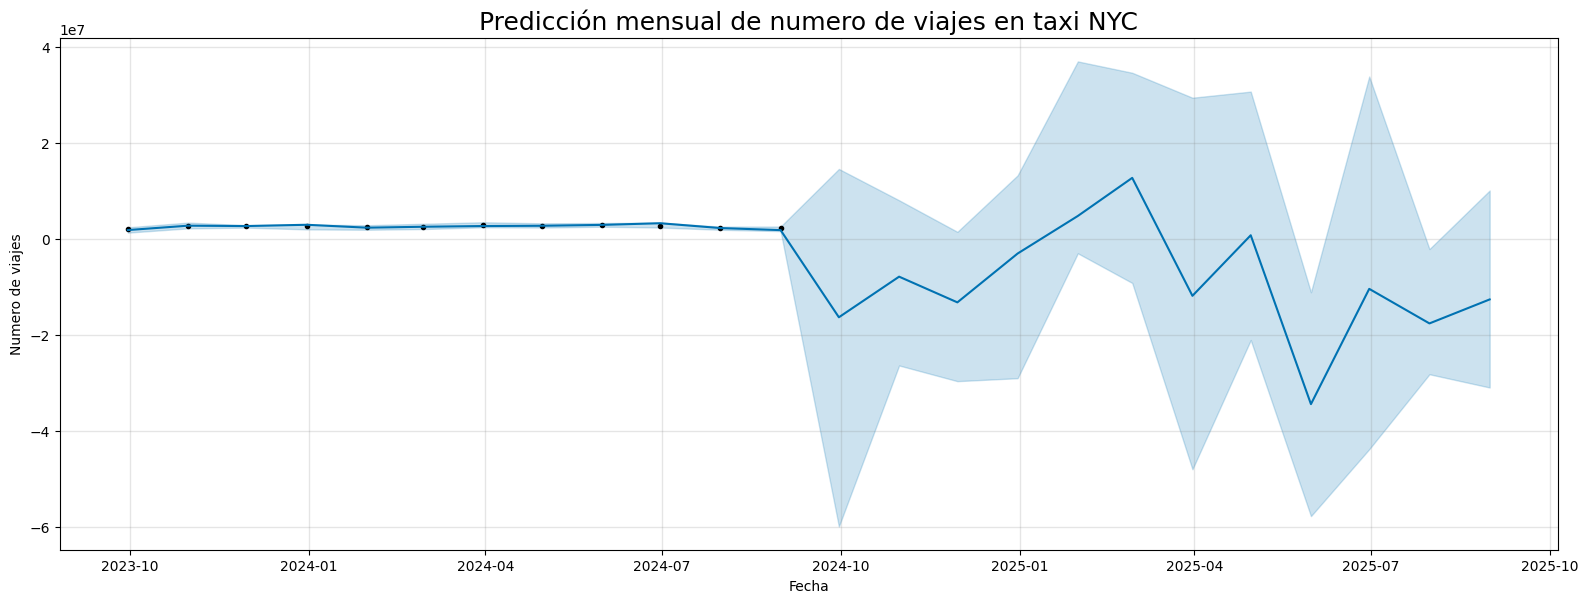

In [ ]:
# plot forecasts

prophet_3.plot(forecast_3, xlabel='Fecha', ylabel='Numero de viajes', figsize = (16,6))
plt.title('Predicción mensual de numero de viajes en taxi NYC', fontsize = 18)
plt.show()

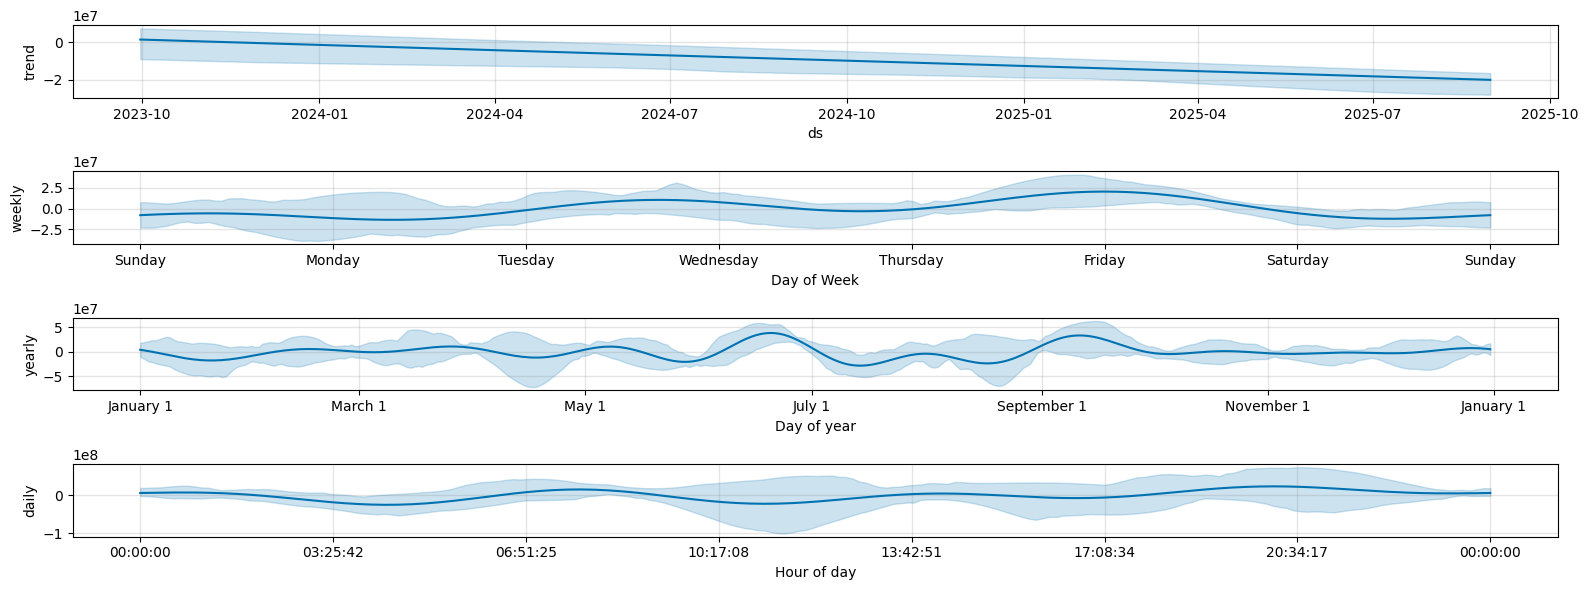

In [ ]:
# Ploteamos los componentes de nuestra serie de tiempo

components = prophet_3.plot_components(forecast_3, figsize=(16,6))

#### Evaluacion

In [ ]:
df_cv_3 = cross_validation(prophet_3, initial = '60 days', horizon = '60 days')

INFO:prophet:Making 8 forecasts with cutoffs between 2023-12-05 00:00:00 and 2024-07-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/3kjtesl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/6eyjur34.json
20:03:37 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=33033', 'data', 'file=/tmp/tmp_62cw8sc/3kjtesl6.json', 'init=/tmp/tmp_62cw8sc/6eyjur34.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_model6ogadb0l/prophet_model-20241113200337_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=33033', 'data', 'file=/tmp/tmp_62cw8sc/3kjtesl6.json', 'init=/tmp/tmp_62cw8sc/6eyjur34.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_model6ogadb0l/prophet_model-20241113200337_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

20:03:37 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=33033', 'data', 'file=/tmp/tmp_62cw8sc/3kjtesl6.json', 'init=/tmp/tmp_62cw8sc/6eyjur34.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_model6ogadb0l/prophet_model-20241113200337_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_62cw8sc/prophet_model6ogadb0l/prophet_model-20241113200337_1.csv
 console_msgs (if any):
	/tmp/tmp_62cw8sc/prophet_model6ogadb0l/prophet_model-20241113200337_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=79149', 'data', 'file=/tmp/tmp_62cw8sc/3t00zc8k.json', 'init=/tmp/tmp_62cw8sc/3iwoe8am.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelaecv25j1/prophet_model-20241113200337_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=79149', 'data', 'file=/tmp/tmp_62cw8sc/3t00zc8k.json', 'init=/tmp/tmp_62cw8sc/3iwoe8am.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelaecv25j1/prophet_model-20241113200337_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

20:03:38 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=79149', 'data', 'file=/tmp/tmp_62cw8sc/3t00zc8k.json', 'init=/tmp/tmp_62cw8sc/3iwoe8am.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelaecv25j1/prophet_model-20241113200337_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_62cw8sc/prophet_modelaecv25j1/prophet_model-20241113200337_1.csv
 console_msgs (if any):
	/tmp/tmp_62cw8sc/prophet_modelaecv25j1/prophet_model-20241113200337_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/nupj7izh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/jlc8br44.json
20:03:38 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=81808', 'data', 'file=/tmp/tmp_62cw8sc/nupj7izh.json', 'init=/tmp/tmp_62cw8sc/jlc8br44.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelte1pgroy/prophet_model-20241113200339_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=81808', 'data', 'file=/tmp/tmp_62cw8sc/nupj7izh.json', 'init=/tmp/tmp_62cw8sc/jlc8br44.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelte1pgroy/prophet_model-20241113200339_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

20:03:39 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=81808', 'data', 'file=/tmp/tmp_62cw8sc/nupj7izh.json', 'init=/tmp/tmp_62cw8sc/jlc8br44.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelte1pgroy/prophet_model-20241113200339_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_62cw8sc/prophet_modelte1pgroy/prophet_model-20241113200339_1.csv
 console_msgs (if any):
	/tmp/tmp_62cw8sc/prophet_modelte1pgroy/prophet_model-20241113200339_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/yi8he_ps.json
20:03:40 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=29234', 'data', 'file=/tmp/tmp_62cw8sc/xfknwgs8.json', 'init=/tmp/tmp_62cw8sc/yi8he_ps.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelt5lmo_25/prophet_model-20241113200340_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=29234', 'data', 'file=/tmp/tmp_62cw8sc/xfknwgs8.json', 'init=/tmp/tmp_62cw8sc/yi8he_ps.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelt5lmo_25/prophet_model-20241113200340_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

20:03:40 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=29234', 'data', 'file=/tmp/tmp_62cw8sc/xfknwgs8.json', 'init=/tmp/tmp_62cw8sc/yi8he_ps.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelt5lmo_25/prophet_model-20241113200340_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_62cw8sc/prophet_modelt5lmo_25/prophet_model-20241113200340_1.csv
 console_msgs (if any):
	/tmp/tmp_62cw8sc/prophet_modelt5lmo_25/prophet_model-20241113200340_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/cwxe7gdw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/1zvah_pn.json
20:03:41 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=92280', 'data', 'file=/tmp/tmp_62cw8sc/cwxe7gdw.json', 'init=/tmp/tmp_62cw8sc/1zvah_pn.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelmnez9w9x/prophet_model-20241113200341_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=92280', 'data', 'file=/tmp/tmp_62cw8sc/cwxe7gdw.json', 'init=/tmp/tmp_62cw8sc/1zvah_pn.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelmnez9w9x/prophet_model-20241113200341_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

20:03:42 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=92280', 'data', 'file=/tmp/tmp_62cw8sc/cwxe7gdw.json', 'init=/tmp/tmp_62cw8sc/1zvah_pn.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelmnez9w9x/prophet_model-20241113200341_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_62cw8sc/prophet_modelmnez9w9x/prophet_model-20241113200341_1.csv
 console_msgs (if any):
	/tmp/tmp_62cw8sc/prophet_modelmnez9w9x/prophet_model-20241113200341_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


INFO:prophet:n_changepoints greater than number of observations. Using 5.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/9xn5uhfa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/lcoghm6t.json
20:03:43 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=69529', 'data', 'file=/tmp/tmp_62cw8sc/9xn5uhfa.json', 'init=/tmp/tmp_62cw8sc/lcoghm6t.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modellx1zwt6o/prophet_model-20241113200343_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=69529', 'data', 'file=/tmp/tmp_62cw8sc/9xn5uhfa.json', 'init=/tmp/tmp_62cw8sc/lcoghm6t.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modellx1zwt6o/prophet_model-20241113200343_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

20:03:45 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=69529', 'data', 'file=/tmp/tmp_62cw8sc/9xn5uhfa.json', 'init=/tmp/tmp_62cw8sc/lcoghm6t.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modellx1zwt6o/prophet_model-20241113200343_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_62cw8sc/prophet_modellx1zwt6o/prophet_model-20241113200343_1.csv
 console_msgs (if any):
	/tmp/tmp_62cw8sc/prophet_modellx1zwt6o/prophet_model-20241113200343_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/7oe6q7z4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/hfhc90ph.json
20:03:45 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=77340', 'data', 'file=/tmp/tmp_62cw8sc/7oe6q7z4.json', 'init=/tmp/tmp_62cw8sc/hfhc90ph.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modela652toyz/prophet_model-20241113200346_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=77340', 'data', 'file=/tmp/tmp_62cw8sc/7oe6q7z4.json', 'init=/tmp/tmp_62cw8sc/hfhc90ph.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modela652toyz/prophet_model-20241113200346_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

20:03:47 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=77340', 'data', 'file=/tmp/tmp_62cw8sc/7oe6q7z4.json', 'init=/tmp/tmp_62cw8sc/hfhc90ph.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modela652toyz/prophet_model-20241113200346_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_62cw8sc/prophet_modela652toyz/prophet_model-20241113200346_1.csv
 console_msgs (if any):
	/tmp/tmp_62cw8sc/prophet_modela652toyz/prophet_model-20241113200346_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/w5dgpgc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_62cw8sc/191sfu05.json
20:03:47 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=88247', 'data', 'file=/tmp/tmp_62cw8sc/w5dgpgc6.json', 'init=/tmp/tmp_62cw8sc/191sfu05.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelol5tpwe3/prophet_model-20241113200347_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=88247', 'data', 'file=/tmp/tmp_62cw8sc/w5dgpgc6.json', 'init=/tmp/tmp_62cw8sc/191sfu05.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelol5tpwe3/prophet_model-20241113200347_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

20:03:48 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=88247', 'data', 'file=/tmp/tmp_62cw8sc/w5dgpgc6.json', 'init=/tmp/tmp_62cw8sc/191sfu05.json', 'output', 'file=/tmp/tmp_62cw8sc/prophet_modelol5tpwe3/prophet_model-20241113200347_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_62cw8sc/prophet_modelol5tpwe3/prophet_model-20241113200347_1.csv
 console_msgs (if any):
	/tmp/tmp_62cw8sc/prophet_modelol5tpwe3/prophet_model-20241113200347_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


In [ ]:
df_cv_3


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-12-31,1.962907e+07,-4.977241e+07,8.705697e+07,2625768,2023-12-05
1,2024-01-31,-3.060234e+07,-8.168394e+07,5.879553e+07,2409342,2023-12-05
2,2024-01-31,4.046802e+07,-7.864526e+05,9.458594e+07,2409342,2024-01-04
3,2024-02-29,3.810623e+07,3.255013e+06,7.941343e+07,2448952,2024-01-04
4,2024-02-29,3.007854e+07,-8.272627e+06,6.551549e+07,2448952,2024-02-03
5,2024-03-31,3.156560e+07,-2.021289e+07,1.116089e+08,2858661,2024-02-03
6,2024-03-31,-3.677982e+07,-7.679098e+07,1.815845e+06,2858661,2024-03-04
7,2024-04-30,-2.154453e+07,-7.514538e+07,4.185467e+07,2777362,2024-03-04
8,2024-04-30,3.694868e+07,1.172774e+05,9.187567e+07,2777362,2024-04-03
9,2024-05-31,6.180645e+07,-1.228359e+07,1.197656e+08,2899539,2024-04-03


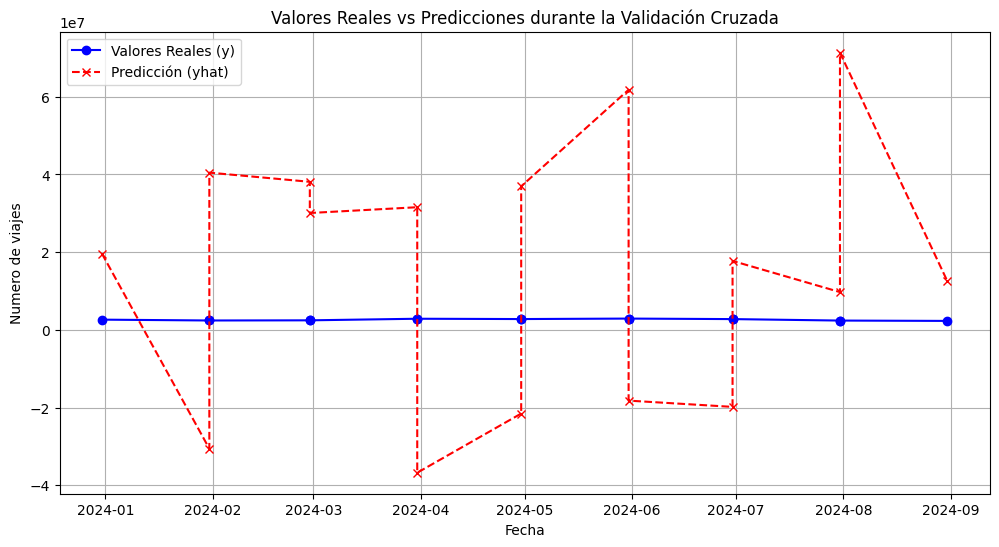

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_cv_3['ds'], df_cv_3['y'], label='Valores Reales (y)', color='blue', marker='o')
plt.plot(df_cv_3['ds'], df_cv_3['yhat'], label='Predicción (yhat)', color='red', linestyle='--', marker='x')

plt.xlabel('Fecha')
plt.ylabel('Numero de viajes')
plt.title('Valores Reales vs Predicciones durante la Validación Cruzada')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df_p_3 = performance_metrics(df_cv_3)
df_p_3.describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,9,9.000000e+00,9.000000e+00,9.000000e+00,9.000000,9.000000,9.000000,9.000000
mean,44 days 10:40:00,1.251766e+15,3.047426e+07,2.991500e+07,11.690239,11.588678,1.688193,0.685185
std,16 days 03:11:42.148646023,1.462977e+15,1.906494e+07,1.879702e+07,7.734538,7.745370,0.244817,0.428535
min,26 days 00:00:00,5.372892e+13,7.330001e+06,7.330001e+06,3.067266,3.067266,1.210620,0.000000
25%,28 days 00:00:00,3.351463e+14,1.830700e+07,1.804756e+07,6.347961,6.347961,1.613450,0.500000
50%,56 days 00:00:00,8.351380e+14,2.889876e+07,2.868017e+07,10.833607,10.042092,1.758457,1.000000
75%,58 days 00:00:00,1.395784e+15,3.736019e+07,3.728949e+07,14.241409,14.241409,1.870346,1.000000
max,60 days 00:00:00,4.753728e+15,6.894729e+07,6.894729e+07,28.851243,28.851243,1.910378,1.000000


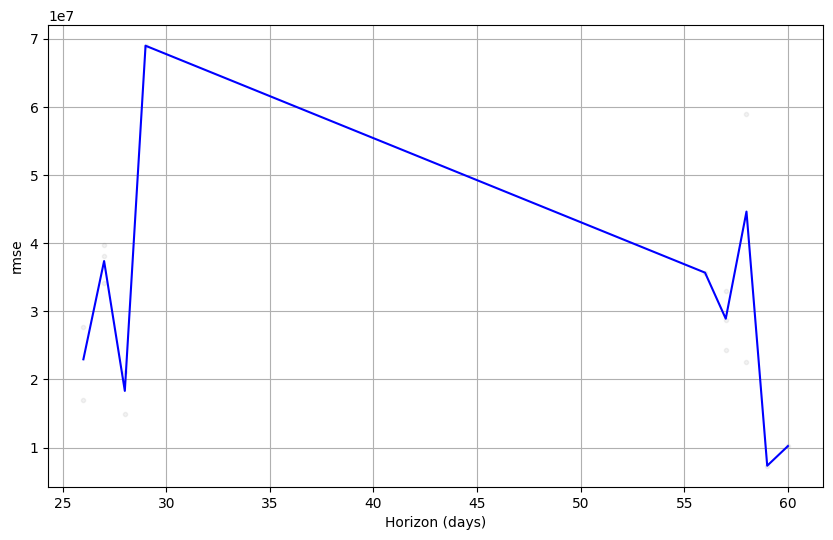

In [ ]:
fig = plot_cross_validation_metric(df_cv_3, metric='rmse')

In [ ]:
print('El RMSE es:', df_p_3.rmse.mean())

El RMSE es: 30474258.06660311


In [ ]:
df_p = performance_metrics(df_cv_3, rolling_window = 1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,60 days,1.161218e+15,3.407665e+07,3.014317e+07,11.520306,10.662151,1.743127,0.75
